In [122]:
%reset

In [1]:
%pwd

'/kaggle/working'

In [ ]:
!nvidia-smi

Fri May 23 10:58:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
system_root = '/kaggle/working'

In [4]:
%cd {system_root}

/kaggle/working


In [5]:
%ls -la {system_root}

total 12
drwxr-xr-x 3 root root 4096 May 23 10:52 ./
drwxr-xr-x 5 root root 4096 May 23 10:52 ../
drwxr-xr-x 2 root root 4096 May 23 10:52 .virtual_documents/


In [6]:
%rm -rf {system_root}/IndustrialMotionDetection

In [7]:
!git clone -b ruslan-dev https://github.com/CTLab-ITMO/IndustrialMotionDetection.git {system_root}/IndustrialMotionDetection

Cloning into '/kaggle/working/IndustrialMotionDetection'...


remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 542 (delta 48), reused 42 (delta 20), pack-reused 460 (from 1)
Receiving objects: 100% (542/542), 74.69 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [8]:
%cd {system_root}/IndustrialMotionDetection/notebooks

/kaggle/working/IndustrialMotionDetection/notebooks


# Load saved checkpoint

In [ ]:
saved_checkpoint_path = f'{system_root}/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13-2025.zip'
saved_checkpoint_path

'/kaggle/working/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-2fsr-11i13-2025.zip'

'/kaggle/working/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13-2025.zip'

In [ ]:
!rm -rf /kaggle/working/runs

In [ ]:
!gdown 1sLRcSgLRZkhigsQiw5RZd1-o6DOAAt-4 --output {saved_checkpoint_path}

Downloading...
From (original): https://drive.google.com/uc?id=1sLRcSgLRZkhigsQiw5RZd1-o6DOAAt-4
From (redirected): https://drive.google.com/uc?id=1sLRcSgLRZkhigsQiw5RZd1-o6DOAAt-4&confirm=t&uuid=ec9be7ff-1900-4162-8efd-5519c68300f5
To: /kaggle/working/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-2fsr-11i13-2025.zip
100%|██████████████████████████████████████| 1.64G/1.64G [00:18<00:00, 91.1MB/s]


In [ ]:
!unzip -o {saved_checkpoint_path} -d {system_root}

Archive:  /kaggle/working/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-2fsr-11i13-2025.zip
   creating: /kaggle/working/runs/
   creating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13__2025__25.04.2025_11-02/
  inflating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13__2025__25.04.2025_11-02/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13.pth  
  inflating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-1fsr-11i13__2025__25.04.2025_11-02/events.out.tfevents.1745578920.6ce8d60ad1db.1678.0  
   creating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_10ep_2bs_16cliplen-1fsr__2025__1743883723/
  inflating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_10ep_2bs_16cliplen-1fsr__2025__1743883723/events.out.tfevents.1743883723.7c7b270d48bb.285.0  
  inflating: /kaggle/working/runs/AL_VideoMAE_MEVA_talksOnPhone_10ep_2bs_16cliplen-1fsr__2025__1743883723/AL_VideoMAE_MEVA_talksOnP

# Imports

In [9]:
%matplotlib inline
import sys
import os
from pathlib import Path

os.environ['CUDA_LAUNCH_BLOCKING']= "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from collections import OrderedDict

from tqdm.notebook import tqdm

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from functools import partial

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

add_path(str(Path().cwd().parent.absolute() / "src"))
print(f"{sys.path=}")

from metrics import compute_metrics_batch_detections

sys.path=['/kaggle/working/IndustrialMotionDetection/src', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [11]:
from models.pooler import make_3d_pooler
from models.box_list import BoxList

In [10]:
from models.model2 import VideoMAEV2

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


ModuleNotFoundError: No module named 'pytorchvideo'

In [12]:
sys.path

['/kaggle/working/IndustrialMotionDetection/src',
 '/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/tmp/tmpuhvefjy7']

# Install libs

In [13]:
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)

In [15]:
!cd {system_root} && \
    git clone https://github.com/itakurah/Focal-loss-PyTorch.git

Cloning into 'Focal-loss-PyTorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 30 (delta 8), reused 26 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 156.11 KiB | 19.51 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [16]:
add_path(f'{system_root}/Focal-loss-PyTorch')

In [17]:
!cd {system_root} && \
    git clone https://github.com/facebookresearch/pytorchvideo.git && \
    cd pytorchvideo

Cloning into 'pytorchvideo'...
remote: Enumerating objects: 2608, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 2608 (delta 100), reused 90 (delta 82), pack-reused 2442 (from 2)
Receiving objects: 100% (2608/2608), 6.22 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (1428/1428), done.


In [18]:
add_path(f'{system_root}/pytorchvideo/pytorchvideo')
add_path(f'{system_root}/pytorchvideo')

In [19]:
sys.path

['/kaggle/working/pytorchvideo',
 '/kaggle/working/pytorchvideo/pytorchvideo',
 '/kaggle/working/Focal-loss-PyTorch',
 '/kaggle/working/IndustrialMotionDetection/src',
 '/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor',
 '/root/.ipython',
 '/tmp/tmpuhvefjy7']

In [20]:
%pip install -q av
%pip install -q iopath
%pip list | grep "av"
%pip install -q 'git+https://github.com/facebookresearch/fvcore'
%pip list | grep "fvcore"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 51.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
av                                 14.4.0
haversine                          2.9.0
PyWavelets                         1.8.0
wavio                              0.0.9
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
fvcore                             0.1.6
Note: you may need to restart the kernel to use updated packages.


In [21]:
from typing import Tuple, Callable
from pytorchvideo.models.head import create_res_roi_pooling_head

def configure_detection_head(embed_dim, num_class):
    head_in_features = embed_dim
    model_num_class = num_class

    # Model configs.
    dropout_rate: float = 0.5
    head_output_size: Tuple[int] = (1, 1, 1)

    # Head configs.
    head_activation: Callable = nn.Sigmoid
    head_output_with_global_average: bool = True
    head_spatial_resolution: Tuple[int] = (7, 7)
    head_spatial_scale: float = 1.0 / 16.0
    head_sampling_ratio: int = 0

    return create_res_roi_pooling_head(
        in_features=head_in_features,
        out_features=model_num_class,
        pool=None,
        output_size=head_output_size,
        dropout_rate=dropout_rate,
        activation=head_activation,
        output_with_global_average=head_output_with_global_average,
        resolution=head_spatial_resolution,
        spatial_scale=head_spatial_scale,
        sampling_ratio=head_sampling_ratio,
    )

In [22]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from typing import Tuple
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from dataclasses import dataclass


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 400, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5),
        **kwargs
    }


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, attn_head_dim=attn_head_dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, num_frames=16, tubelet_size=2):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.tubelet_size = int(tubelet_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) * (
                    num_frames // self.tubelet_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv3d(in_channels=in_chans, out_channels=embed_dim,
                              kernel_size=(self.tubelet_size, patch_size[0], patch_size[1]),
                              stride=(self.tubelet_size, patch_size[0], patch_size[1]))

    def forward(self, x, **kwargs):
        # B, C, T, H, W = x.shape
        x = self.proj(x)
        return x


# sin-cos position encoding
# https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py#L31
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.tensor(sinusoid_table,dtype=torch.float, requires_grad=False).unsqueeze(0) 


@dataclass
class ROIPoolingCfg:
    POOLER_RESOLUTION: int = 7
    POOLER_SCALE: float = 0.0625
    POOLER_SAMPLING_RATIO: int = 0
    POOLER_TYPE: str = 'align3d'
    MEAN_BEFORE_POOLER: bool = True


class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 num_classes=80,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 norm_layer=nn.LayerNorm,
                 init_values=0.,
                 use_learnable_pos_emb=False,
                 init_scale=0.,
                 all_frames=16,
                 tubelet_size=2,
                 use_checkpoint=False,
                 use_mean_pooling=True):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.tubelet_size = tubelet_size
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim, num_frames=all_frames,
            tubelet_size=self.tubelet_size)
        num_patches = self.patch_embed.num_patches  # 8x14x14
        self.use_checkpoint = use_checkpoint
        self.grid_size = [img_size//patch_size, img_size//patch_size]  # [14,14]

        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        else:
            # sine-cosine positional embeddings is on the way
            self.pos_embed = get_sinusoid_encoding_table(num_patches, embed_dim)

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values)
            for i in range(depth)])

        self.norm = norm_layer(embed_dim)  
        self.fc_norm = None
        
        self.detection_head_hidden_dim = 256
        self.detection_head = configure_detection_head(embed_dim, num_classes)
        self.detection_head.proj = nn.Sequential(
            nn.Linear(embed_dim, self.detection_head_hidden_dim),    # Expanded projection
            nn.GELU(),                                               # Non-linearity
            nn.Linear(self.detection_head_hidden_dim, num_classes)   # Project back to original dimension
        )

        # self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        # rois setting
        # self.head_cfg = ROIPoolingCfg()
        # self.pooler = make_3d_pooler(self.head_cfg)
        # resolution = self.head_cfg.POOLER_RESOLUTION
        # self.max_pooler = nn.MaxPool2d((resolution, resolution))

        self.test_ext = (0.1, 0.05)
        self.proposal_per_clip = 100

        if use_learnable_pos_emb:
            trunc_normal_(self.pos_embed, std=.02)

        # trunc_normal_(self.head.weight, std=.02)
        self.apply(self._init_weights)

        # self.head.weight.data.mul_(init_scale)
        # self.head.bias.data.mul_(init_scale)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    # def reset_classifier(self, num_classes, global_pool=''):
    #     self.num_classes = num_classes
    #     self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        B, width, t, h, w = x.size()
        x = x.flatten(2).transpose(1, 2)

        if self.pos_embed is not None:  
            pos_embed = self.pos_embed.reshape(t, -1, width)
            pos_embed = interpolate_pos_embed_online(
                pos_embed, self.grid_size, [h, w], 0).reshape(1, -1, width)
            x = x + pos_embed.expand(B, -1, -1).type_as(x).to(x.device).clone().detach()
        
        x = self.pos_drop(x)

        if self.use_checkpoint:
            for blk in self.blocks:
                x = checkpoint.checkpoint(blk, x)
        else:   
            for blk in self.blocks:
                x = blk(x)

        x = self.norm(x)  # [b thw=8x14x14 c=768]
        x = x.reshape(B, t, h, w, -1).permute(0, 4, 1, 2, 3) # [b c t h w]
        x = x.mean(dim=2, keepdim=True)  # [b c 1 h w]
        return x

    def sample_box(self, boxes):
        proposals = []
        num_proposals = self.proposal_per_clip
        for boxes_per_image in boxes:
            num_boxes = len(boxes_per_image)

            if num_boxes > num_proposals:
                choice_inds = torch.randperm(num_boxes)[:num_proposals]
                proposals_per_image = boxes_per_image[choice_inds]
            else:
                proposals_per_image = boxes_per_image
            proposals_per_image = proposals_per_image.random_aug(0.2, 0.1, 0.1, 0.05)
            proposals.append(proposals_per_image)
        return proposals
    
    def convert_to_roi_format(self, boxes, dtype, device):
        bbox_list = list()
        ids_list = list()
        for i, b in enumerate(boxes):
            if not b:
                bbox_list.append(torch.zeros((0, 4), dtype=dtype, device=device))
                ids_list.append(torch.zeros((0, 1), dtype=dtype, device=device))
            else:
                bbox_list.append(b.bbox.to(dtype))
                ids_list.append(torch.full((len(b), 1), i, dtype=dtype, device=device))
        concat_boxes = torch.cat(bbox_list, dim=0)
        ids = torch.cat(ids_list, dim=0)
        rois = torch.cat([ids, concat_boxes], dim=1)
        return rois 

    def forward(self, x, boxes):
        if self.training:
            proposals = self.sample_box(boxes)
        else:
            proposals = [box.extend(self.test_ext) for box in boxes]
        x = self.forward_features(x)
        print(f"{x.shape=}")
        # x = x.reshape(B, t, h, w, -1).permute(0, 4, 1, 2, 3)  # [b c t h w]
        # x = x.mean(dim=2, keepdim=False)  # [b c h w]
        # rois = self.pooler(x, proposals)  # [n c 7 7]
        # rois = self.max_pooler(rois).view(rois.size(0), -1)  # [n c]
        # rois = self.head(rois) # [n, num_cls]
        proposals = self.convert_to_roi_format(proposals, x.dtype, x.device)
        print(f"{proposals=}")
        rois = self.detection_head(x, proposals)
        return rois


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_384(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=384, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_512(pretrained=False, **kwargs):
    model = VisionTransformer(
        img_size=512, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    model.default_cfg = _cfg()
    return model


def interpolate_pos_embed_online(
    pos_embed, orig_size: Tuple[int], new_size: Tuple[int], num_extra_tokens: int
):
    extra_tokens = pos_embed[:, :num_extra_tokens]
    pos_tokens = pos_embed[:, num_extra_tokens:]
    embedding_size = pos_tokens.shape[-1]
    pos_tokens = pos_tokens.reshape(
        -1, orig_size[0], orig_size[1], embedding_size
    ).permute(0, 3, 1, 2)
    pos_tokens = torch.nn.functional.interpolate(
        pos_tokens, size=new_size, mode="bicubic", align_corners=False,
    )
    pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
    new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
    return new_pos_embed

<ipython-input-22-38f31514cafe>:363: UserWarning: Overwriting vit_small_patch16_224 in registry with __main__.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
<ipython-input-22-38f31514cafe>:372: UserWarning: Overwriting vit_base_patch16_224 in registry with __main__.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_224(pretrained=False, **kwargs):
<ipython-input-22-38f31514cafe>:381: UserWarning: Overwriting vit_base_patch16_384 in registry with __main__.vit_base_patch16_384. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_384(pretrained=False, **kwargs):
<ipython-input-22-38f31514cafe>:390: UserWarning: Overwriting vit_large_patch16_224 in registry w

In [23]:
import math
import random
from collections import Counter
import pandas as pd
import numpy as np
import torch
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader
from video.encoded_video import EncodedVideo
from logger import Logger


class RandomDatasetDecord(IterableDataset):
    def __init__(
        self,
        data_folder_path: str,
        csv_file_path: str,
        class2idx: dict,
        video_transform=None,
        epoch_size_ratio=1.0,
        frame_sample_rate=1,
        clip_len=16,
        num_classes=5
    ):
        super().__init__()
        
        SHOW_LOG = True
        self.logger = Logger(SHOW_LOG).get_logger(__name__)

        self.class2idx = class2idx
        
        self.data_folder_path = data_folder_path

        self.data = pd.read_csv(csv_file_path, low_memory=False)

        self.offset_frames = 15
        self.offset_sec = 0.4
        self.frames_per_second = 30
        
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.clip_duration = (self.clip_len * self.frame_sample_rate) / self.frames_per_second
        
        self.video_paths = self.data.video_path.unique()
        self.video_paths_len = len(self.video_paths)
        self.epoch_size = int(self.video_paths_len * epoch_size_ratio)
        
        self.num_classes = num_classes
        self.video_transform = video_transform
        
        unique_tracks_per_category = (
            self.data.groupby(['video_path', 'track_id', 'action_category'])
            .size()
            .groupby('action_category')
            .size()
            .reset_index(name='unique_tracks')
        )
        self.category_to_tracks = dict(zip(
            unique_tracks_per_category['action_category'], 
            unique_tracks_per_category['unique_tracks']))
        
        unique_frames_per_category = (
            self.data.groupby(['video_path', 'keyframe_id', 'action_category'])
            .size()
            .groupby('action_category')
            .size()
            .reset_index(name='unique_frames')
        )
        self.category_to_frames = dict(zip(
            unique_frames_per_category['action_category'], 
            unique_frames_per_category['unique_frames']))
        
        self.action_weights = self._calculate_action_weights()
        print(self.action_weights)
        
        self.grouped_data = self.data.groupby(['video_path', 'track_id'])
        self.groups = list(self.grouped_data.groups.keys())
        
        self.group_weights = self._calculate_group_weights()

    def _calculate_action_weights(self, alpha=0.5):
        """
        Calculate class weights based on inverse frequency with smoothing factor alpha
        """
        total_frames = sum(self.category_to_frames.values())
        total_tracks = sum(self.category_to_tracks.values())
        action_weights = {}
        for k in self.category_to_tracks.keys():
            frames_ratio = total_frames / self.category_to_frames[k]
            tracks_ratio = total_tracks / self.category_to_tracks[k]
            action_weights[k] = frames_ratio * tracks_ratio
        return action_weights
    
    def _calculate_group_weights(self):
        """
        Calculate sampling weights for each (video, track) group based on action frequency
        """
        group_weights = []
        for group_key in self.groups:
            group = self.grouped_data.get_group(group_key)
            main_action = str(group['action_category'].value_counts().idxmax())
            group_weights.append(self.action_weights[main_action])
        total = sum(group_weights)
        return [w/total for w in group_weights]

    def __len__(self):
        return self.epoch_size
    
    def _sample_consecutive_frames(self, group_annots, video_annots):
        group_frames = group_annots['keyframe_id'].unique()
        video_frames = video_annots['keyframe_id'].unique()
        
        max_available_frame_id = max(video_frames) 
        
        def clip(frame_id):
            return max(0, min(max_available_frame_id, frame_id))

        missing_count = self.offset_frames
        count_frames = max(group_frames) - min(group_frames) + 1 
        if count_frames < self.clip_len:
            missing_count = max(missing_count, math.ceil((self.clip_len - count_frames)/2))
        
        act_start_frame_id = random.randint(
            min(group_frames), 
            max(min(group_frames) + 1, max(group_frames) - (self.clip_len - 1))
        )
        
        start_frame_id = clip(act_start_frame_id - missing_count)
        end_frame_id = clip(act_start_frame_id + (self.clip_len - 1) + missing_count)
        return start_frame_id, end_frame_id 

    def __iter__(self):
        for _ in range(self.epoch_size):
            # Sample (video_path, track_id) pair
            group_key = random.choices(self.groups, weights=self.group_weights, k=1)[0]
            video_path, track_id = group_key
            
            group_annots = self.grouped_data.get_group(group_key)
            video_annots = self.data.loc[self.data["video_path"] == video_path]
            
            start_frame_id, end_frame_id = self._sample_consecutive_frames(group_annots, video_annots) 
        
            video_src = EncodedVideo.from_path(f"{self.data_folder_path}/{video_path}")
            # start_sec from offset_sec, since 30 padding frames
            start_sec = start_frame_id / self.frames_per_second
            end_sec = min(video_src.duration, math.ceil(end_frame_id / self.frames_per_second)) 
            # Load the desired clip [C, T, H, W]
            video_data = video_src.get_clip(start_sec=start_sec, end_sec=end_sec)['video']
            video_src.close()
            del video_src
            
            keyframe_id = (start_frame_id + end_frame_id) // 2
            frame_video_annots = video_annots[video_annots["keyframe_id"] == keyframe_id]

            if len(frame_video_annots) == 0:
                print(f"INFO: Zero annots found for {video_path} at {keyframe_id}")
                
            # Convert to a PyTorch tensor of shape Nx4
            boxes = torch.tensor(
                frame_video_annots[["xmin", "ymin", "xmax", "ymax"]].values.astype(float),
                dtype=torch.float32)

            action_categories = frame_video_annots[["action_category"]].values.reshape(-1)

            one_hot_target = torch.zeros(
                (len(action_categories), self.num_classes),
                dtype=torch.bool)

            for i, c in enumerate(action_categories):
                one_hot_target[i][self.class2idx[c]] = True

            one_hot_target = one_hot_target.to(torch.long)

            if len(frame_video_annots) > 1:
                print(f"INFO: {len(frame_video_annots)} annots for {video_path} at {keyframe_id}")
                
            data = {
                "path": f"{video_path}-{keyframe_id}",
                "video": video_data, # [CxTxHxW]
                "target": one_hot_target, # [N, cls]
                "bbox": boxes, # [N, 4]
            }

            if self.video_transform:
                data = self.video_transform(data)
                
            video_h, video_w = data['video'].shape[-2:]
            data['bbox'] = BoxList(data['bbox'], (video_w, video_h))

            yield data


def collate_fn(batch):
    video_list = []
    target_list = []
    bbox_list = []
    path_list = []

    for sample in batch:
        video_list.append(sample["video"])
        target_list.append(sample["target"]) # [N, cls]
        bbox_list.append(sample["bbox"])
        path_list.append(sample["path"])

    videos = torch.stack(video_list)

    return {
        "video": videos, # [B, C, T, H, W]
        "target": target_list, # [B, N, num_cls]
        "bbox": bbox_list, # [B, BoxList[N]]
        "path": path_list
    }
    

def get_dataloaders(
    train_csv_file_path: str, 
    val_csv_file_path: str,
    num_classes: str,
    batch_size, 
    seed, 
    frame_sample_rate=1, 
    clip_len=16,
    val_epoch_size_ratio: float = 1.0,
    train_epoch_size_ratio: float = 1.0):
    
    image_datasets = dict()
    image_datasets['train'] = RandomDatasetDecord(
        train_csv_file_path,
        epoch_size_ratio=train_epoch_size_ratio,
        video_transform=None,
        frame_sample_rate=frame_sample_rate,
        clip_len=clip_len,
        num_classes=num_classes)

    image_datasets['test'] = RandomDatasetDecord(
        val_csv_file_path,
        epoch_size_ratio=val_epoch_size_ratio,
        video_transform=None,
        frame_sample_rate=frame_sample_rate,
        clip_len=clip_len,
        num_classes=num_classes)
    
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(seed)
    
    dataloaders = dict()
    dataloaders['train'] = DataLoader(
        image_datasets['train'],
        batch_size=batch_size,
        pin_memory=True,
        drop_last=True,
        collate_fn=collate_fn,
        worker_init_fn=seed_worker,
        generator=g)
    
    dataloaders['test'] = DataLoader(
        image_datasets['test'],
        batch_size=batch_size,
        pin_memory=True,
        collate_fn=collate_fn,
        worker_init_fn=seed_worker,
        generator=g)

    return dataloaders


# Variables

In [24]:
seed = 2025
torch_deterministic = True

train_ratio = 0.8
test_ratio = 1 - train_ratio

lr = 1e-4
save_frequency = 1
num_epochs = 100

batch_size = 4
clip_len = 16 # NOTE: unchangeable for VideoMAE model
frame_sample_rate = 2

train_epoch_size_ratio = 1.0
val_epoch_size_ratio = 1.0

evaluation_step = 2

exp_name = f"AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_{num_epochs}ep_{batch_size}bs_{clip_len}cliplen-{frame_sample_rate}fsr-15"

In [25]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [26]:
seed_everything(seed)

In [27]:
cls = [
    'person_talks_on_phone',
    'person_texts_on_phone',
    'person_interacts_with_laptop',
    'person_reads_document',
    'person_picks_up_object',
]

class_to_idx = {'background': 0}
class_to_idx.update({cl: i+1 for i, cl in enumerate(cls)})
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_to_idx, idx_to_class

({'background': 0,
  'person_talks_on_phone': 1,
  'person_texts_on_phone': 2,
  'person_interacts_with_laptop': 3,
  'person_reads_document': 4,
  'person_picks_up_object': 5},
 {0: 'background',
  1: 'person_talks_on_phone',
  2: 'person_texts_on_phone',
  3: 'person_interacts_with_laptop',
  4: 'person_reads_document',
  5: 'person_picks_up_object'})

In [28]:
num_classes = len(class_to_idx)
num_classes

6

# Check MEVA train and test subsets

In [29]:
!ls -la /kaggle/input 

total 16
drwxr-xr-x 8 root   root    4096 May 23 10:52 .
drwxr-xr-x 5 root   root    4096 May 23 10:52 ..
drwxr-xr-x 3 nobody nogroup    0 May 23 10:49 meva-processed-2018-03-07
drwxr-xr-x 4 nobody nogroup    0 May 23 10:49 meva-processed-2018-03-11i13
drwxr-xr-x 3 nobody nogroup    0 May 23 10:49 meva-processed-2018-03-15-2
drwxr-xr-x 6 nobody nogroup    0 May 23 10:49 meva-processed-2018-03-15i12i05i09
drwxr-xr-x 3 root   root    4096 May 23 10:52 videomae_pretrain_15_1
drwxr-xr-x 3 root   root    4096 May 23 10:51 yolovideomae_pretrained_15_localization_finetuning


In [30]:
dataset_root = '/kaggle/input/meva-processed-2018-03-15-2'

In [31]:
train_csv_file_path = f'{dataset_root}/train.csv'
val_csv_file_path = f'{dataset_root}/test.csv'

In [32]:
df = pd.read_csv(val_csv_file_path, index_col=['video_path', 'keyframe_id'])
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
df.head(10)

track_id  \
video_path                                         keyframe_id             
2018-03-15/15/2018-03-15.15-40-00.15-45-00.scho... 0                   1   
                                                   0                   5   
                                                   0                 106   
                                                   1                   1   
                                                   1                   5   
                                                   1                 106   
                                                   2                   1   
                                                   2                   5   
                                                   2                 106   
                                                   3                   1   

                                                                             action_category  \
video_path                                         keyframe_id                                 
2018-03-15/15/2018-03-15.15-40-00.15-45-00.scho... 0            person_interacts_with_laptop   
                                                   0                   person_texts_on_phone   
                                                   0                   person_texts_on_phone   
                                                   1            person_interacts_with_laptop   
                                                   1                   person_texts_on_phone   
                                                   1                   person_texts_on_phone   
                                                   2            person_interacts_with_laptop   
                                                   2                   person_texts_on_phone   
                                                   2                   person_texts_on_phone   
                                                   3            person_interacts_with_laptop   

                                                                xmin  ymin  \
video_path                                         keyframe_id               
2018-03-15/15/2018-03-15.15-40-00.15-45-00.scho... 0             247   276   
                                                   0             404   265   
                                                   0             887   318   
                                                   1             247   276   
                                                   1             404   265   
                                                   1             887   318   
                                                   2             247   276   
                                                   2             404   265   
                                                   2             887   318   
                                                   3             247   276   

                                                                xmax  ymax  
video_path                                         keyframe_id              
2018-03-15/15/2018-03-15.15-40-00.15-45-00.scho... 0             375   452  
                                                   0             513   423  
                                                   0            1033   584  
                                                   1             375   452  
                                                   1             513   423  
                                                   1            1033   584  
                                                   2             375   452  
                                                   2             513   423  
                                                   2            1033   584  
                                                   3             375   452

# Initialize dataset

In [33]:
# from data.data_transform import get_transform
# transform = get_transform(16, 1024)

from transforms_impl.transforms import (
    Compose,
    Lambda,
    NormalizeVideo,
    ShortSideScaleWithBoxes,
    UniformTemporalSubsample,
    RandomCropVideoWithBoxes
)

from typing import Dict


def uniform_temporal_subsample(
    x: torch.Tensor, num_samples: int, temporal_dim: int = -3
) -> torch.Tensor:
    """
    Uniformly subsamples num_samples indices from the temporal dimension of the video.
    When num_samples is larger than the size of temporal dimension of the video, it
    will sample frames based on nearest neighbor interpolation.

    Args:
        x (torch.Tensor): A video tensor with dimension larger than one with torch
            tensor type includes int, long, float, complex, etc.
        num_samples (int): The number of equispaced samples to be selected
        temporal_dim (int): dimension of temporal to perform temporal subsample.

    Returns:
        An x-like Tensor with subsampled temporal dimension.
    """
    t = x.shape[temporal_dim]
    assert num_samples > 0 and t > 0
    # Sample by nearest neighbor interpolation if num_samples > t.
    indices = torch.linspace(0, t - 1, num_samples)
    indices = torch.clamp(indices, 0, t - 1).long()
    indices = indices.to(x.device)
    return torch.index_select(x, temporal_dim, indices)


class UniformTemporalSubsample(torch.nn.Module):
    """
    ``nn.Module`` wrapper for ``transforms_impl.functional.uniform_temporal_subsample``.
    """

    def __init__(self, num_samples: int, temporal_dim: int = -3):
        """
        Args:
            num_samples (int): The number of equispaced samples to be selected
            temporal_dim (int): dimension of temporal to perform temporal subsample.
        """
        super().__init__()
        self._num_samples = num_samples
        self._temporal_dim = temporal_dim

    def forward(
        self, 
        target: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """
        Args:
            x (torch.Tensor): video tensor with shape (C, T, H, W).
        """
        target['video'] = uniform_temporal_subsample(
            target['video'], self._num_samples, self._temporal_dim)
        return target


def get_transform(clip_len: int, clip_size: int):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    pixel_max_value = 255.0
    return Compose([
        UniformTemporalSubsample(clip_len),
        # Lambda(lambda x: x/pixel_max_value),
        # NormalizeVideo(mean, std),
        ShortSideScaleWithBoxes(size=clip_size),
        RandomCropVideoWithBoxes(size=clip_size),
    ])
    
transform = get_transform(16, 1024)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(


In [34]:
image_datasets = dict()
image_datasets['train'] = RandomDatasetDecord(
    dataset_root,
    train_csv_file_path,
    class2idx=class_to_idx,
    video_transform=transform,
    epoch_size_ratio=train_epoch_size_ratio,
    frame_sample_rate=frame_sample_rate,
    clip_len=clip_len,
    num_classes=num_classes)
image_datasets['test'] = RandomDatasetDecord(
    data_folder_path=dataset_root,
    csv_file_path=val_csv_file_path,
    class2idx=class_to_idx,
    video_transform=transform,
    epoch_size_ratio=val_epoch_size_ratio,
    frame_sample_rate=frame_sample_rate,
    clip_len=clip_len,
    num_classes=num_classes)

{'person_interacts_with_laptop': 487.40223602593807, 'person_picks_up_object': 494.38284120075883, 'person_reads_document': 61.75010063637873, 'person_talks_on_phone': 121.96018354463136, 'person_texts_on_phone': 3.0069843745929608}
{'person_interacts_with_laptop': 161.50697069943288, 'person_picks_up_object': 155.38448422847398, 'person_reads_document': 198.20857650342552, 'person_talks_on_phone': 182.8083313831032, 'person_texts_on_phone': 3.328149565202572}


In [35]:
len(image_datasets['train']), len(image_datasets['test'])

(107, 28)

In [33]:
for i, x in tqdm(enumerate(image_datasets['train']), total=len(image_datasets['train'])):
    if i == 1: break
    print(x['video'].shape)
    print(x['target'])
    print(x['path'])
    print(x['bbox'])
    print()
    pass

  0%|          | 0/107 [00:00<?, ?it/s]

torch.Size([3, 16, 1024, 1024])
tensor([], size=(0, 6), dtype=torch.int64)
2018-03-15/15/2018-03-15.15-05-00.15-10-00.school.G638_frange5723-5801.avi-31
BoxList(num_boxes=0, image_width=1024, image_height=1024, mode=xyxy)



In [36]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

dataloaders = dict()
dataloaders['train'] = DataLoader(
    image_datasets['train'],
    batch_size=batch_size,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn,
    worker_init_fn=seed_worker,
    generator=g)
dataloaders['test'] = DataLoader(
    image_datasets['test'],
    batch_size=batch_size,
    pin_memory=True,
    collate_fn=collate_fn,
    worker_init_fn=seed_worker,
    generator=g)

In [37]:
len(dataloaders['train']), len(dataloaders['test'])

(26, 7)

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 3 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 3118
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 1926
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G508_frange0-1259.avi at 778
2018-03-15/15/2018-03-15.15-45-00.15-50-00.bus.G508_frange8814-8890.avi-30
2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi-3118
2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi-1926
2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G508_frange0-1259.avi-778
batch['video'].shape=torch.Size([4, 3, 16, 1024, 1024])
len(batch['bbox'])=4
len(batch['target'])=4
----------------------------------------------------------------------------------------------------
video.shape=torch.Size([16, 3, 1024, 1024])
pixel range: 0.0 - 255.0
bbox_coords=[[259.6802062988281, 430.7989807128906, 338.9625244140625, 562.6177368164062]]
gt_targets=[[0, 0, 0, 0, 0, 1]]
------------

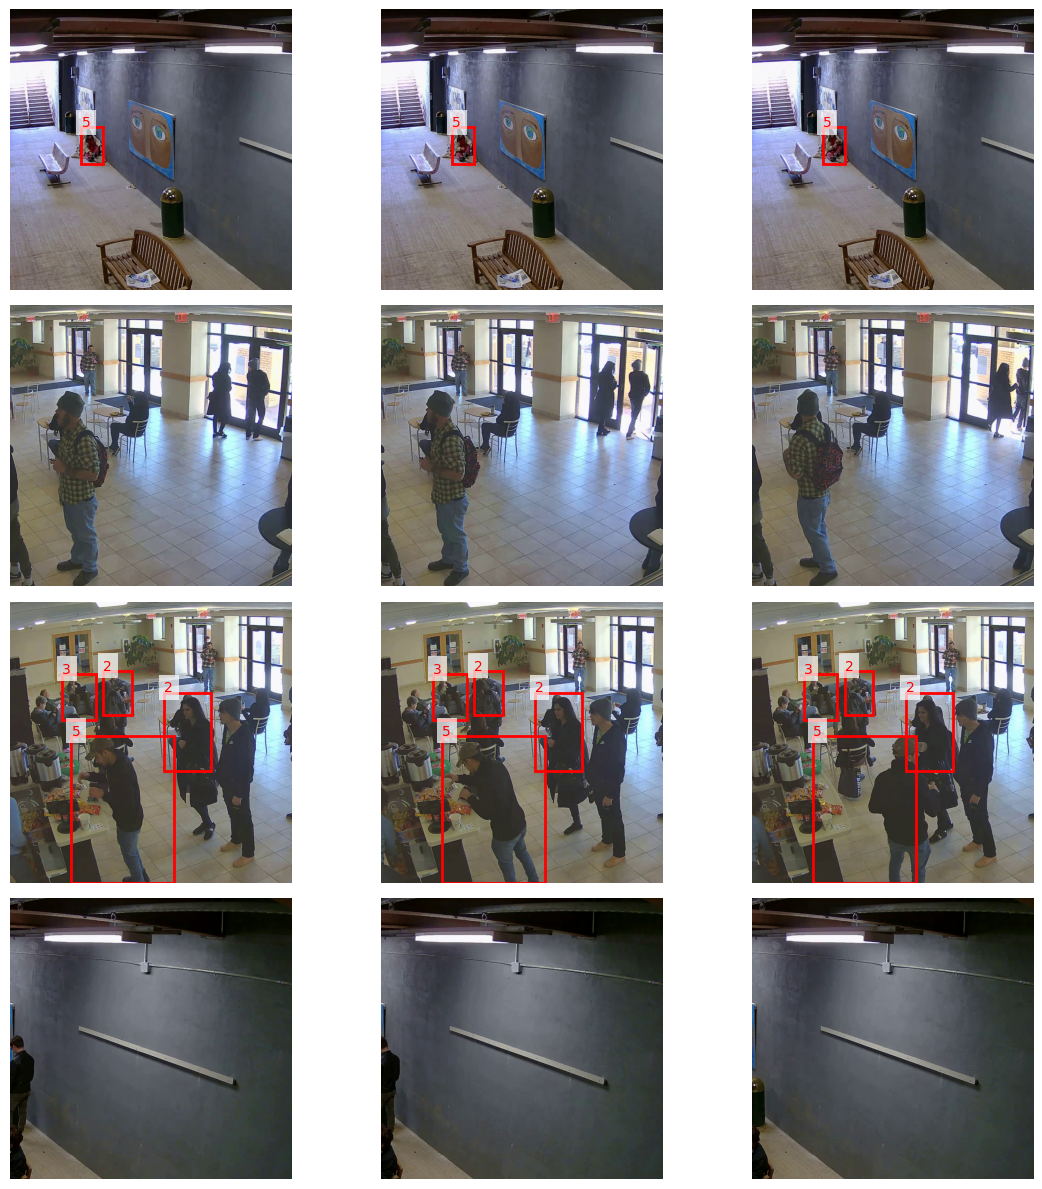

INFO: 6 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5654
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5443
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5579
Elapsed: 54.775832414627075


In [36]:
tqdm_progress = tqdm(enumerate(dataloaders['test']), total=len(dataloaders['test']))

count_targets = {k: 0 for k in class_to_idx.keys()}

for i, batch in tqdm_progress:
    if i == 1: break
    
    print('\n'.join(batch['path']))
    print(f"{batch['video'].shape=}")
    print(f"{len(batch['bbox'])=}")
    print(f"{len(batch['target'])=}")
    print('-' * 100)
    
    idx2pos = {0: 0, 1: 7, 2: 15}
    
    fig, axes = plt.subplots(batch_size, len(idx2pos), figsize=(12, 12))
    
    for batch_idx in range(batch_size):    
        
        video = batch['video'][batch_idx].permute(1, 0, 2, 3)
        
        bbox_coords = batch['bbox'][batch_idx].bbox.tolist()

        gt_targets = batch['target'][batch_idx].tolist()
        
        print(f"{video.shape=}")
        print(f"pixel range: {video.min()} - {video.max()}")
        print(f"{bbox_coords=}")
        print(f"{gt_targets=}")
        print('-' * 50 + f"#{batch_idx}" + '-' * 50)
            
        # single batch actions
        for target in gt_targets:
            target_idx = np.argmax(target)
            count_targets[idx_to_class[target_idx]] += 1
        
        for j in range(len(idx2pos)):
            img = video[idx2pos[j]].permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())

            axes[batch_idx][j].imshow(img)
            axes[batch_idx][j].axis('off')

            for bbox_coord, target in zip(bbox_coords, gt_targets):
                x_min, y_min, x_max, y_max = bbox_coord
                width = x_max - x_min
                height = y_max - y_min
                
                rect = patches.Rectangle(
                    (x_min, y_min), width, height,
                    linewidth=2, edgecolor='red', facecolor='none')
                axes[batch_idx][j].add_patch(rect)
                
                axes[batch_idx][j].text(
                    x_min, y_min - 5, str(np.argmax(target)), 
                    color='red', fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    plt.tight_layout()
    plt.show()

print(f"Elapsed: {tqdm_progress.format_dict['elapsed']}")

In [38]:
import gc
gc.collect()

0

# Load weights

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
%ls -la /kaggle/input/videomae_pretrain_15_1/pytorch/default/1/results/pretrained_videomae_meva_15__0__19.05.2025_18-54/

total 6625860
drwxr-xr-x 2 nobody nogroup          0 May 23 10:49 ./
drwxr-xr-x 3 nobody nogroup          0 May 23 10:49 ../
-rw-r--r-- 1 nobody nogroup 1130807786 May 23 10:52 checkpoint-19.pth
-rw-r--r-- 1 nobody nogroup 1130807786 May 23 10:52 checkpoint-29.pth
-rw-r--r-- 1 nobody nogroup 1130807786 May 23 10:51 checkpoint-39.pth
-rw-r--r-- 1 nobody nogroup 1130807786 May 23 10:51 checkpoint-49.pth
-rw-r--r-- 1 nobody nogroup 1130807786 May 23 10:51 checkpoint-59.pth
-rw-r--r-- 1 nobody nogroup 1130806910 May 23 10:51 checkpoint-9.pth
-rw-r--r-- 1 nobody nogroup      15611 May 23 10:49 log.txt


In [41]:
# finetune = f"{system_root}/checkpoint.pth"
finetune = "/kaggle/input/videomae_pretrain_15_1/pytorch/default/1/results/pretrained_videomae_meva_15__0__19.05.2025_18-54/checkpoint-49.pth"

In [40]:
!gdown '1nU-H1u3eJ-VuyCveU7v-WIOcAVxs5Hww' --output {finetune}

Error:

	[Errno 30] Read-only file system: '/kaggle/input/videomae_pretrain_15_
	1/pytorch/default/1/results/pretrained_videomae_meva_15__0__19.05.2025
	_18-54/checkpoint-49.pth48lkhpqa.part'

To report issues, please visit https://github.com/wkentaro/gdown/issues.


In [41]:
!wget https://huggingface.co/OpenGVLab/VideoMAE2/resolve/main/distill/vit_s_k710_dl_from_giant.pth -O {finetune}

--2025-05-16 07:20:47--  https://huggingface.co/OpenGVLab/VideoMAE2/resolve/main/distill/vit_s_k710_dl_from_giant.pth
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.90, 3.163.189.37, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/30/fa/30fa9ef7e6a7cb70be94a7eb1e5e244f3e43d4844e147c41fc5965a78822fe01/24fb71687fa3671b8387cadfbcbab0f72af695692e93cf1ecc82caa888626172?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27vit_s_k710_dl_from_giant.pth%3B+filename%3D%22vit_s_k710_dl_from_giant.pth%22%3B&Expires=1747383647&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NzM4MzY0N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzMwL2ZhLzMwZmE5ZWY3ZTZhN2NiNzBiZTk0YTdlYjFlNWUyNDRmM2U0M2Q0ODQ0ZTE0N2M0MWZjNTk2NWE3ODgyMmZlMDEvMjRmYjcxNjg3ZmEzNjcxYjgzODdjYWRmYmNiYWIwZjcyYWY2OTU2OTJlOTNjZ

In [42]:
checkpoint = torch.load(finetune, map_location=device)
checkpoint_model = checkpoint['model']

<ipython-input-42-24a85d9f5fb8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(finetune, map_location=device)


In [43]:
# --------------------------------------------------------
# Based on BEiT, timm, DINO and DeiT code bases
# https://github.com/microsoft/unilm/tree/master/beit
# https://github.com/rwightman/pytorch-image-models/tree/master/timm
# https://github.com/facebookresearch/deit
# https://github.com/facebookresearch/dino
# --------------------------------------------------------'
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from typing import Tuple, Callable
from pytorchvideo.models.head import create_res_roi_pooling_head


def configure_detection_head(embed_dim, num_class):
    head_in_features = embed_dim
    model_num_class = num_class

    # Model configs.
    dropout_rate: float = 0.5
    head_output_size: Tuple[int] = (1, 1, 1)

    # Head configs.
    head_activation: Callable = nn.Sigmoid
    head_output_with_global_average: bool = True
    head_spatial_resolution: Tuple[int] = (7, 7)
    head_spatial_scale: float = 1.0 / 16.0
    head_sampling_ratio: int = 0

    return create_res_roi_pooling_head(
        in_features=head_in_features,
        out_features=model_num_class,
        pool=None,
        output_size=head_output_size,
        dropout_rate=dropout_rate,
        activation=head_activation,
        output_with_global_average=head_output_with_global_average,
        resolution=head_spatial_resolution,
        spatial_scale=head_spatial_scale,
        sampling_ratio=head_sampling_ratio,
    )


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 400,
        'input_size': (3, 224, 224),
        'pool_size': None,
        'crop_pct': .9,
        'interpolation': 'bicubic',
        'mean': (0.5, 0.5, 0.5),
        'std': (0.5, 0.5, 0.5),
        **kwargs
    }


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)


class Mlp(nn.Module):

    def __init__(self,
                 in_features,
                 hidden_features=None,
                 out_features=None,
                 act_layer=nn.GELU,
                 drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement
        x = self.fc2(x)
        x = self.drop(x)
        return x


class CosAttention(nn.Module):

    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.,
                 attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        # self.scale = qk_scale or head_dim**-0.5
        # DO NOT RENAME [self.scale] (for no weight decay)
        if qk_scale is None:
            self.scale = nn.Parameter(
                torch.log(10 * torch.ones((num_heads, 1, 1))),
                requires_grad=True)
        else:
            self.scale = qk_scale

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat(
                (self.q_bias,
                 torch.zeros_like(self.v_bias,
                                  requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[
            2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (
            F.normalize(q, dim=-1) @ F.normalize(k, dim=-1).transpose(-2, -1))

        # torch.log(torch.tensor(1. / 0.01)) = 4.6052
        logit_scale = torch.clamp(self.scale, max=4.6052).exp()

        attn = attn * logit_scale

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Attention(nn.Module):

    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop=0.,
                 proj_drop=0.,
                 attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat(
                (self.q_bias,
                 torch.zeros_like(self.v_bias,
                                  requires_grad=False), self.v_bias))
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[
            2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop=0.,
                 attn_drop=0.,
                 drop_path=0.,
                 init_values=None,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm,
                 attn_head_dim=None,
                 cos_attn=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        if cos_attn:
            self.attn = CosAttention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                attn_head_dim=attn_head_dim)
        else:
            self.attn = Attention(
                dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                attn_drop=attn_drop,
                proj_drop=drop,
                attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop)

        if init_values > 0:
            self.gamma_1 = nn.Parameter(
                init_values * torch.ones((dim)), requires_grad=True)
            self.gamma_2 = nn.Parameter(
                init_values * torch.ones((dim)), requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 embed_dim=768,
                 num_frames=16,
                 tubelet_size=2):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_spatial_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        num_patches = num_spatial_patches * (num_frames // tubelet_size)

        self.img_size = img_size
        self.tubelet_size = tubelet_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv3d(
            in_channels=in_chans,
            out_channels=embed_dim,
            kernel_size=(self.tubelet_size, patch_size[0], patch_size[1]),
            stride=(self.tubelet_size, patch_size[0], patch_size[1]))

    def forward(self, x, **kwargs):
        B, C, T, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[
            1], f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        # b, c, l -> b, l, c
        x = self.proj(x)
        return x


# sin-cos position encoding
# https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/Models.py#L31
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    # TODO: make it with torch instead of numpy
    def get_position_angle_vec(position):
        return [
            position / np.power(10000, 2 * (hid_j // 2) / d_hid)
            for hid_j in range(d_hid)
        ]

    sinusoid_table = np.array(
        [get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.tensor(
        sinusoid_table, dtype=torch.float, requires_grad=False).unsqueeze(0)


class VideoMAEV2(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """

    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 num_classes=1000,
                 embed_dim=768,
                 depth=12,
                 num_heads=12,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0.,
                 head_drop_rate=0.,
                 norm_layer=nn.LayerNorm,
                 init_values=0.,
                 use_learnable_pos_emb=False,
                 init_scale=0.,
                 all_frames=16,
                 tubelet_size=2,
                 use_mean_pooling=True,
                 with_cp=False,
                 cos_attn=False):
        super().__init__()
        self.num_classes = num_classes
        # num_features for consistency with other models
        self.num_features = self.embed_dim = embed_dim
        self.tubelet_size = tubelet_size
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            num_frames=all_frames,
            tubelet_size=tubelet_size)
        num_patches = self.patch_embed.num_patches
        self.with_cp = with_cp

        if use_learnable_pos_emb:
            self.pos_embed = nn.Parameter(
                torch.zeros(1, num_patches, embed_dim))
        else:
            # sine-cosine positional embeddings is on the way
            self.pos_embed = get_sinusoid_encoding_table(
                num_patches, embed_dim)

        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)
               ]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
                init_values=init_values,
                cos_attn=cos_attn) for i in range(depth)
        ])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None
        # self.head_dropout = nn.Dropout(head_drop_rate)
        # self.head = nn.Linear(
        #     embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        
        self.detection_head_hidden_dim = 256
        self.detection_head = configure_detection_head(embed_dim, num_classes)
        self.detection_head.proj = nn.Sequential(
            nn.Linear(embed_dim, self.detection_head_hidden_dim),    # Expanded projection
            nn.GELU(),                                               # Non-linearity
            nn.Linear(self.detection_head_hidden_dim, num_classes)   # Project back to original dimension
        )

        if use_learnable_pos_emb:
            trunc_normal_(self.pos_embed, std=.02)

        self.apply(self._init_weights)

        # self.head.weight.data.mul_(init_scale)
        # self.head.bias.data.mul_(init_scale)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    # def get_classifier(self):
    #     return self.head

    # def reset_classifier(self, num_classes, global_pool=''):
    #     self.num_classes = num_classes
    #     self.head = nn.Linear(
    #         self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.size(0)

        x = self.patch_embed(x)
        B, width, t, h, w = x.size()
        x = x.flatten(2).transpose(1, 2)

        if self.pos_embed is not None:
            x = x + self.pos_embed.expand(B, -1, -1).type_as(x).to(
                x.device).clone().detach()
        
        x = self.pos_drop(x)

        for blk in self.blocks:
            if self.with_cp:
                x = cp.checkpoint(blk, x)
            else:
                x = blk(x)
        
        x = self.norm(x)  # [b thw=8x14x14 c=768]
        x = x.reshape(B, t, h, w, -1).permute(0, 4, 1, 2, 3) # [b c t h w]
        x = x.mean(dim=2, keepdim=True)  # [b c 1 h w]
        # if self.fc_norm is not None:
        #     return self.fc_norm(x.mean(1))
        # else:
        #     return self.norm(x[:, 0])
        return x
        
    def convert_to_roi_format(self, boxes, dtype, device):
        bbox_list = list()
        ids_list = list()
        for i, b in enumerate(boxes):
            if not b:
                bbox_list.append(torch.zeros((0, 4), dtype=dtype, device=device))
                ids_list.append(torch.zeros((0, 1), dtype=dtype, device=device))
            else:
                bbox_list.append(b.bbox.to(dtype))
                ids_list.append(torch.full((len(b), 1), i, dtype=dtype, device=device))
        concat_boxes = torch.cat(bbox_list, dim=0)
        ids = torch.cat(ids_list, dim=0)
        rois = torch.cat([ids, concat_boxes], dim=1)
        return rois 

    def forward(self, x, proposals):
        x = self.forward_features(x)
        print(f"features {x.shape=}")
        # x = self.head_dropout(x)
        # x = self.head(x)
        proposals = self.convert_to_roi_format(proposals, x.dtype, x.device)
        rois = self.detection_head(x, proposals)
        return rois


@register_model
def vit_small_patch16_224(pretrained=False, **kwargs):
    model = VideoMAEV2(
        patch_size=16,
        embed_dim=384,
        depth=12,
        num_heads=6,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_base_patch16_224(pretrained=False, **kwargs):
    model = VideoMAEV2(
        patch_size=16,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_large_patch16_224(pretrained=False, **kwargs):
    model = VideoMAEV2(
        patch_size=16,
        embed_dim=1024,
        depth=24,
        num_heads=16,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_huge_patch16_224(pretrained=False, **kwargs):
    model = VideoMAEV2(
        patch_size=16,
        embed_dim=1280,
        depth=32,
        num_heads=16,
        mlp_ratio=4,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def vit_giant_patch14_224(pretrained=False, **kwargs):
    model = VideoMAEV2(
        patch_size=14,
        embed_dim=1408,
        depth=40,
        num_heads=16,
        mlp_ratio=48 / 11,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs)
    model.default_cfg = _cfg()
    return model


<ipython-input-43-d695579e8eb7>:521: UserWarning: Overwriting vit_small_patch16_224 in registry with __main__.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
<ipython-input-43-d695579e8eb7>:536: UserWarning: Overwriting vit_base_patch16_224 in registry with __main__.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_224(pretrained=False, **kwargs):
<ipython-input-43-d695579e8eb7>:551: UserWarning: Overwriting vit_large_patch16_224 in registry with __main__.vit_large_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_large_patch16_224(pretrained=False, **kwargs):
<ipython-input-43-d695579e8eb7>:566: UserWarning: Overwriting vit_huge_patch16_224 in registry

In [44]:
# model = VisionTransformer(
#     patch_size=16,
#     num_classes=num_classes,
#     embed_dim=384,
#     depth=12,
#     num_heads=6,
#     mlp_ratio=4,
#     qkv_bias=True,
#     drop_rate=0.0,
#     drop_path_rate=0.2,
#     attn_drop_rate=0.0,
#     norm_layer=partial(nn.LayerNorm, eps=1e-6),
#     init_scale=0.001,
#     all_frames=16,
#     tubelet_size=2,
#     use_checkpoint=False,
#     use_mean_pooling=True)

model = VideoMAEV2(
    patch_size=16,
    num_classes=num_classes,
    embed_dim=768,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    qkv_bias=True,
    drop_rate=0.0,
    drop_path_rate=0.2,
    attn_drop_rate=0.0,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    init_scale=0.001,
    all_frames=16,
    tubelet_size=2,
    use_mean_pooling=False
).to(device)

In [45]:
for name, param in model.named_parameters():
    if (name.startswith('rpn_network')
        or name.startswith('bbox_head')
        or name.startswith('head')
        or name.startswith('roi_heads')
        or name.startswith('detection_head')
        or name.startswith('fc_norm')):
        continue
    param.requires_grad = False

In [46]:
len(checkpoint_model.keys())

218

In [47]:
checkpoint_model.keys()

odict_keys(['_orig_mod.mask_token', '_orig_mod.encoder.patch_embed.proj.weight', '_orig_mod.encoder.patch_embed.proj.bias', '_orig_mod.encoder.blocks.0.norm1.weight', '_orig_mod.encoder.blocks.0.norm1.bias', '_orig_mod.encoder.blocks.0.attn.q_bias', '_orig_mod.encoder.blocks.0.attn.v_bias', '_orig_mod.encoder.blocks.0.attn.qkv.weight', '_orig_mod.encoder.blocks.0.attn.proj.weight', '_orig_mod.encoder.blocks.0.attn.proj.bias', '_orig_mod.encoder.blocks.0.norm2.weight', '_orig_mod.encoder.blocks.0.norm2.bias', '_orig_mod.encoder.blocks.0.mlp.fc1.weight', '_orig_mod.encoder.blocks.0.mlp.fc1.bias', '_orig_mod.encoder.blocks.0.mlp.fc2.weight', '_orig_mod.encoder.blocks.0.mlp.fc2.bias', '_orig_mod.encoder.blocks.1.norm1.weight', '_orig_mod.encoder.blocks.1.norm1.bias', '_orig_mod.encoder.blocks.1.attn.q_bias', '_orig_mod.encoder.blocks.1.attn.v_bias', '_orig_mod.encoder.blocks.1.attn.qkv.weight', '_orig_mod.encoder.blocks.1.attn.proj.weight', '_orig_mod.encoder.blocks.1.attn.proj.bias', '_or

In [48]:
# print('\n'.join(checkpoint_model.keys()))
if all(['_orig_mod' in k for k in checkpoint_model.keys()]):
    checkpoint_model = {k[10:]: v for k, v in checkpoint_model.items()}

In [49]:
all_keys = list(checkpoint_model.keys())
new_dict = OrderedDict()

for key in all_keys:
    if key.startswith('backbone.'):
        new_dict[key[9:]] = checkpoint_model[key]
    elif key.startswith('encoder.'):
        new_dict[key[8:]] = checkpoint_model[key]
    elif (key.startswith('decoder.')
          or key == 'mask_token'
          or key.startswith('encoder_to_decoder')):
        continue
    else:
        new_dict[key] = checkpoint_model[key]

checkpoint_model = new_dict

In [50]:
model.load_state_dict(checkpoint_model, strict=False)

_IncompatibleKeys(missing_keys=['detection_head.proj.0.weight', 'detection_head.proj.0.bias', 'detection_head.proj.2.weight', 'detection_head.proj.2.bias'], unexpected_keys=[])

In [51]:
%pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from models.box_list import BoxList
import cv2
import scipy
from typing import Tuple

def match_bboxes(bbox_gt, bbox_pred, IOU_THRESH=0.5):
    '''
    Given sets of true and predicted bounding-boxes,
    determine the best possible match.
    Parameters
    ----------
    bbox_gt, bbox_pred : N1x4 and N2x4 np array of bboxes [x1,y1,x2,y2]. 
      The number of bboxes, N1 and N2, need not be the same.
    
    Returns
    -------
    (idxs_true, idxs_pred, ious, labels)
        idxs_true, idxs_pred : indices into gt and pred for matches
        ious : corresponding IOU value of each match
        labels: vector of 0/1 values for the list of detections
    '''
    n_true = bbox_gt.shape[0]
    n_pred = bbox_pred.shape[0]
    MAX_DIST = 1.0
    MIN_IOU = 0.0

    # NUM_GT x NUM_PRED
    iou_matrix = np.zeros((n_true, n_pred))
    for i in range(n_true):
        for j in range(n_pred):
            iou_matrix[i, j] = bbox_iou(bbox_gt[i,:], bbox_pred[j,:])
            
    if n_pred > n_true:
      # there are more predictions than ground-truth - add dummy rows
      diff = n_pred - n_true
      iou_matrix = np.concatenate( 
        (iou_matrix, np.full((diff, n_pred), MIN_IOU)), axis=0)

    if n_true > n_pred:
      # more ground-truth than predictions - add dummy columns
      diff = n_true - n_pred
      iou_matrix = np.concatenate( 
        (iou_matrix, np.full((n_true, diff), MIN_IOU)), axis=1)

    # call the Hungarian matching
    idxs_true, idxs_pred = scipy.optimize.linear_sum_assignment(1 - iou_matrix)

    # remove dummy assignments
    sel_pred = idxs_pred<n_pred
    idx_pred_actual = idxs_pred[sel_pred] 
    idx_gt_actual = idxs_true[sel_pred]
    ious_actual = iou_matrix[idx_gt_actual, idx_pred_actual]
    sel_valid = (ious_actual > IOU_THRESH)
    label = sel_valid.astype(int)

    return idx_gt_actual[sel_valid], idx_pred_actual[sel_valid], ious_actual[sel_valid], label 

    
def bbox_iou(boxA, boxB):
    # Determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = xB - xA + 1
    interH = yB - yA + 1

    # Correction: reject non-overlapping boxes
    if interW <=0 or interH <=0 :
        return -1.0

    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def rescale_bboxes(
    boxes: torch.Tensor, 
    box_size: Tuple[int, int], 
    target_size: Tuple[int, int]
) -> torch.Tensor:
    """
    Rescale bounding boxes from original image size to target size.
    
    Args:
        boxes: Tensor of shape [N, 4] where each row is (x1, y1, x2, y2)
        box_size: Original image size as (width, height)
        target_size: Target image size as (width, height)
    
    Returns:
        Tensor of shape [N, 4] with rescaled boxes
    """
    orig_width, orig_height = box_size
    target_width, target_height = target_size

    scales = torch.tensor(
        [target_width / orig_width, target_height / orig_height,
        target_width / orig_width, target_height / orig_height],
        device=boxes.device, dtype=boxes.dtype)
    return boxes * scales

class YOLO_VideoMAE:
    def __init__(
        self, video_model, criterion,          
        yolo_model_name="yolo11n.pt",
        yolo_imgsz=640,
        yolo_lower_conf=0.25,
        yolo_upper_conf=0.5,
        yolo_iou=0.7,
        enable_logging=False,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    ):
        self.device = device
        
        self.yolo_imgsz = yolo_imgsz
        self.yolo_lower_conf = yolo_lower_conf
        self.yolo_upper_conf = yolo_upper_conf
        self.yolo_iou = yolo_iou
        self.yolo_classes = [0]
        self.yolo_agnostic_nms = True
        self.yolo_verbose_inference = False
        self.yolo_model = YOLO(
            yolo_model_name
        ).to(self.device)
        
        self.video_model = video_model
        self.criterion = criterion
        
        self.unknown_class_limit = 3
        
        self.video_model_img_size = 224
        self.max_pixel_value = 255
        self.clip_len = 16
        
        self.video_transform = get_transform(
            clip_len=self.clip_len, 
            clip_size=self.video_model_img_size)
        
        self.total_targets = 0
        self.matched_targets = 0
        
        self.enable_logging = enable_logging
        
        
    def get_match_rate(self):
        return self.matched_targets / self.total_targets
        
    def draw_rect_image(
        self,
        image, 
        box, 
        label: str = None,
        color = (0, 255, 0)
    ):
        font_scale = 0.5
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(
            image, 
            (x1, y1), (x2, y2), color, 2)
        
        if label is not None:
            (text_width, text_height), _ = cv2.getTextSize(
                label, 
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
            
            cv2.rectangle(
                image, 
                (x1, y1 - text_height - 10), (x1 + text_width, y1), 
                color, -1)
            
            cv2.putText(
                image, label, (x1, y1 - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1)
    
    def __call__(self, x, gt_boxes, gt_labels):
        if self.enable_logging:
            print(f"{x.shape=}")
        
        batch_count, c, t, h, w = x.shape # [B, C, T, H, W]
        target_size = (w, h)
        
        if self.enable_logging:
            print(f"target_size: {target_size}")
        
        # [B, C, T, H, W] -> [B, C, H, W]
        image = x[:, :, t//2]
        
        results = self.yolo_model(
            image/self.max_pixel_value, 
            conf=self.yolo_lower_conf,
            iou=self.yolo_iou,
            imgsz=self.yolo_imgsz, 
            agnostic_nms=self.yolo_agnostic_nms,
            classes=self.yolo_classes,
            verbose=self.yolo_verbose_inference,
        )
        
        if self.enable_logging:
            print(f"YOLO model output: {len(results)=}")
        
        gt_targets = [] # targets (List[Dict])
        yolo_proposals = [] # proposals (List[Tensor[N, 4]]) 
        yolo_targets = []
        batch_scores = []
        
        for i, result in enumerate(results):
            # img_with_boxes = image.numpy()[i].astype(np.uint8).transpose((1, 2, 0)).copy()
            
            xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
            names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
            confs = result.boxes.conf  # confidence score of each box
            
            bboxes = []
            scores = []
            
            for box, cls_name, conf in zip(xyxy, names, confs):
                if conf < self.yolo_upper_conf:
                    continue
                
                # label = f"{cls_name} {conf:.2f}"
                # self.draw_rect_image(img_with_boxes, box, label)
     
                bboxes.append(box)
                scores.append(conf)
                
            if len(bboxes) == 0:
                bboxes.append(torch.Tensor([0, 0, 1, 1]))
                scores.append(0.0)
            
            if self.enable_logging:           
                print(f"Gathered {len(bboxes)} proposals for image #{i}")
            
            bboxes = BoxList(torch.stack(bboxes, dim=0).to(device), image_size=(w, h)) \
                .resize((self.video_model_img_size, self.video_model_img_size))  
            scores_tensor = torch.tensor(scores).to(device)
            
            gt_target_dict = {}
            gt_target_dict['video'] = x[i].detach().clone()
            gt_target_dict['bbox'] = gt_boxes[i].bbox.detach().clone()  # [N, 4] float tensor
            gt_target_dict['target'] = gt_labels[i].argmax(dim=1).detach().clone() # Tensor[N]
            
            # for box in target_dict['bbox']:
            #     self.draw_rect_image(img_with_boxes, box.tolist(), color=(255, 0, 0))
            # plt.imshow(img_with_boxes)
            # plt.show()
                
            gt_target_dict = self.video_transform(gt_target_dict)
            gt_targets.append(gt_target_dict)
            
            if self.enable_logging:
                print(f"{gt_target_dict['bbox']=}")
                print(f"{gt_target_dict['target']=}")
                print(f"{bboxes.bbox=}")
            
            UKNOWN_CLS = 0
            idxs_true, idxs_pred, ious, labels_matched = match_bboxes(gt_target_dict['bbox'], bboxes.bbox)
            idxs_pred = torch.tensor(idxs_pred, device=device)
            
            assert len(idxs_true) == len(idxs_pred), "true and pred idxs len should be equal"
            
            if self.enable_logging:
                print(f"Matching info:\n{idxs_true=}\n{idxs_pred.tolist()=}\n{ious=}\n{labels_matched=}\n")
                
            # Create mask for matched boxes
            matched_mask = torch.zeros(len(bboxes), dtype=torch.bool)
            matched_mask[idxs_pred] = True
            # Get indices of non-matched boxes
            non_matched_indices = torch.where(~matched_mask)[0].to(device)
            # Select up to 3 non-matched boxes
            num_non_matched = min(self.unknown_class_limit, len(non_matched_indices))
            # Combine matched and selected non-matched indices
            keep_indices = torch.cat([idxs_pred, non_matched_indices[:num_non_matched]]).unique()
            # Filter boxes and scores
            filtered_bboxes = bboxes.keep_boxes(keep_indices)
            filtered_scores = scores_tensor[keep_indices]
            
            yolo_target = torch.full(size=(len(filtered_bboxes),), fill_value=UKNOWN_CLS).to(device)
            
            # Map original matched indices to new indices
            new_indices = torch.where(torch.isin(keep_indices, idxs_pred))[0]
            
            yolo_target[new_indices] = gt_target_dict['target'][idxs_true]
            
            if self.enable_logging:
                print(f"{yolo_target=}")
            
            self.total_targets += len(gt_target_dict['bbox'])
            self.matched_targets += len(idxs_pred) 
            
            # Change target dict to match yolo bboxes
            yolo_targets.append(yolo_target) # Tensor[N]
            yolo_proposals.append(filtered_bboxes)
            batch_scores.append(filtered_scores)
            
            
        x = torch.stack([t['video'] for t in gt_targets], dim=0)
        labels = torch.cat(yolo_targets, dim=0)
        
        if self.enable_logging:
            print(f"\nInput video shape: {x.shape=}")
            print(f"Target shape: {labels.shape=} {labels=}")
        
        logits = self.video_model(x, yolo_proposals) # Tensor[n, num_cls]
        
        if self.enable_logging:
            print(f"VideoMAE results shape: {logits.shape=}")
        
        scores = torch.softmax(logits, dim=1) # Tensor[n, num_cls]
    
        losses = {'loss': self.criterion(logits, labels)}
        detection_results = []
        
        prev = 0
        for i in range(batch_count):
            batch_len = len(yolo_proposals[i])
            
            detection_result_dict = {}
            detection_result_dict['boxes'] = rescale_bboxes(
                yolo_proposals[i].bbox, 
                yolo_proposals[i].size, 
                target_size
            )
            max_values, max_indices = scores[prev:prev+batch_len].max(dim=1)
            detection_result_dict['scores'] = max_values
            detection_result_dict['labels'] = max_indices 
    
            prev += batch_len
            
            detection_results.append(detection_result_dict)

        return detection_results, losses

In [94]:
image_datasets['train']._calculate_action_weights()

{'person_interacts_with_laptop': 487.40223602593807,
 'person_picks_up_object': 494.38284120075883,
 'person_reads_document': 61.75010063637873,
 'person_talks_on_phone': 121.96018354463136,
 'person_texts_on_phone': 3.0069843745929608}

In [88]:
class_weights = torch.full((num_classes,), fill_value=1.0).to(device)
class_weights[0] = 0.1
# max_weight = -math.inf
# min_weight = math.inf
# for class_name, weight in image_datasets['train']._calculate_action_weights().items():
#     max_weight = max(max_weight, weight)
#     min_weight = min(min_weight, weight)
#     class_weights[class_to_idx[class_name]] = weight
    
# class_weights[0] = min_weight / 10
# class_weights = class_weights / max_weight
# torch.set_printoptions(precision=3)
class_weights

tensor([0.1000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0')

In [95]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [97]:
from focal_loss import FocalLoss

criterion = FocalLoss(
    gamma=2, 
    alpha=class_weights, 
    task_type='multi-class', 
    num_classes=num_classes
)
criterion

FocalLoss()

In [135]:
# let yolo_imgsz be around 2k
detector = YOLO_VideoMAE(
    model, 
    criterion, 
    yolo_model_name="yolo11l.pt", 
    yolo_imgsz=1920, 
    yolo_lower_conf=0.2,
    yolo_upper_conf=0.4,
    yolo_iou=0.4,
    enable_logging=True,
    device=device,
)

In [136]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    
model.to(device)

VideoMAEV2(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): At

# Model stats

In [137]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [138]:
count_parameters(model)

198406

# Inference Model

In [129]:
with torch.no_grad():
    vid = torch.rand(1, 3, 16, 224, 224).to(device)

    box_list = [BoxList([[0, 0, 5, 5]], (10, 10)).to(device)]
    print(f"{box_list=}")

    labels = [torch.Tensor([[0, 0, 0, 1, 0, 0]]).to(device)]
    print(f"{labels=}")

    detections, loss = detector(vid, box_list, labels)
    print(f"{detections=}")
    print(f"{loss=}")

box_list=[BoxList(num_boxes=1, image_width=10, image_height=10, mode=xyxy)]
labels=[tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0')]
x.shape=torch.Size([1, 3, 16, 224, 224])
target_size: (224, 224)
YOLO model output: len(results)=1
Gathered 1 proposals for image #0
gt_target_dict['bbox']=tensor([[0., 0., 5., 5.]], device='cuda:0')
gt_target_dict['target']=tensor([3], device='cuda:0')
bboxes.bbox=tensor([[0., 0., 1., 1.]], device='cuda:0')
Matching info:
idxs_true=array([], dtype=int64)
idxs_pred.tolist()=[]
ious=array([], dtype=float64)
labels_matched=array([0])

new_indices=tensor([], device='cuda:0', dtype=torch.int64) keep_indices=tensor([0], device='cuda:0')
yolo_target=tensor([0], device='cuda:0')

Input video shape: x.shape=torch.Size([1, 3, 16, 224, 224])
Target shape: labels.shape=torch.Size([1]) labels=tensor([0], device='cuda:0')
features x.shape=torch.Size([1, 768, 1, 14, 14])
VideoMAE results shape: logits.shape=torch.Size([1, 6])
detections=[{'boxes': tensor([[0., 0., 

In [139]:
def print_detections(dct):
    print("Detections example:")
    for k, v in dct.items():
        print("{}={}".format(k, v))

In [140]:
from metrics_impl.utils import BBFormat, CoordinatesType
from metrics_impl.Evaluator import Evaluator

bi = 0

iouThreshold = .5
showPlot = False
evaluator = Evaluator()

bbFormat = BBFormat.XYWH
coordType = CoordinatesType.Absolute

savePath = os.path.join(system_root, 'results')
os.makedirs(savePath, exist_ok=True)

bboxes_path = os.path.join(savePath, 'bboxes.jpg')

In [141]:
# def rescale(
#     box: Tuple[float, float, float, float], 
#     box_size: Tuple[int, int], 
#     target_size: Tuple[int, int]
# ) -> Tuple[float, float, float, float]:
#     x1, y1, x2, y2 = box
#     orig_width, orig_height = box_size
#     target_width, target_height = target_size
    
#     width_scale = target_width / orig_width
#     height_scale = target_height / orig_height
    
#     return (x1 * width_scale, y1 * height_scale, x2 * width_scale, y2 * height_scale)

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 4346
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5037
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 4808
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 6696
x['video'].shape=torch.Size([4, 3, 16, 1024, 1024])
----------
len(x['target'])=4
x['target'][0].shape=torch.Size([1, 6])
----------
len(x['bbox'])=4
x['bbox'][bi].bbox.shape=torch.Size([1, 4])
x['bbox'][bi].bbox=tensor([[295.6448, 146.1469, 375.8823, 337.1885]])
----------
len(x['path'])=4
x['path'][0]='2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi-4346'
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 8 proposals for image #0
gt_target_dict['bbox']=tensor([[64.6723, 31.9696, 82.2243, 73.7600]], device='cuda:

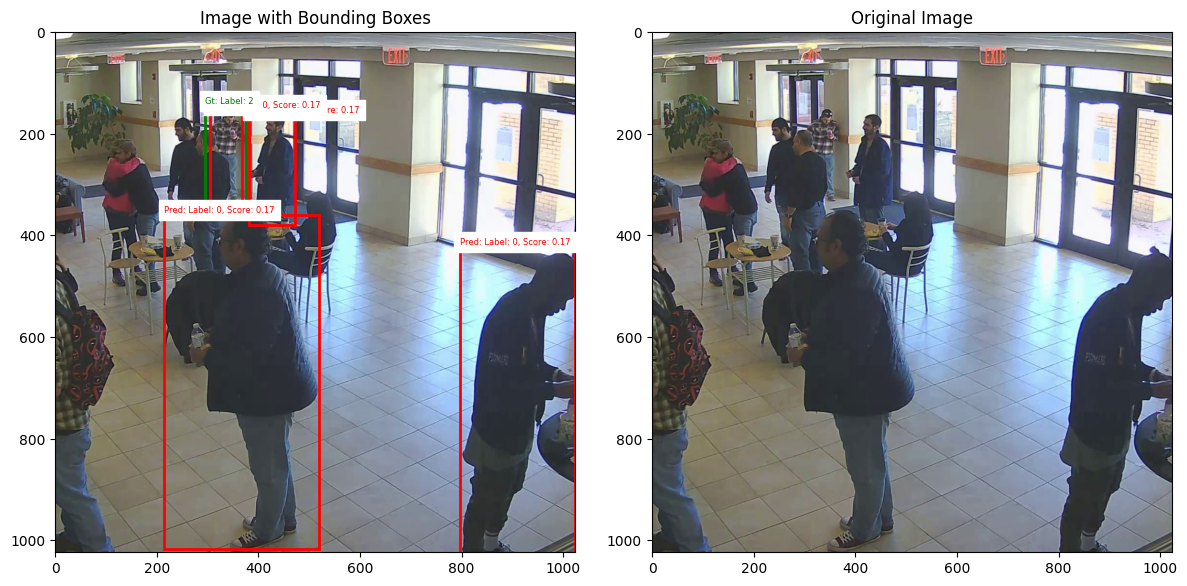

/kaggle/working/IndustrialMotionDetection/src/metrics_impl/Evaluator.py:127: RuntimeWarning: invalid value encountered in divide
  rec = acc_TP / npos


AP: 0.00% (2)
AP: 0.00% (3)
AP: 0.00% (5)
mAP: 0.00%
Detections example:
boxes=tensor([[4.3887e+02, 1.9959e+02, 5.9084e+02, 5.4631e+02],
        [1.2596e+02, 1.5359e+02, 1.9184e+02, 3.3638e+02],
        [1.8272e+01, 2.3002e+02, 1.7828e+02, 4.8687e+02],
        [2.1236e-01, 1.6086e+02, 5.5197e+01, 4.0925e+02]], device='cuda:0')
scores=tensor([0.1727, 0.1735, 0.1731, 0.1719], device='cuda:0')
labels=tensor([0, 0, 0, 0], device='cuda:0')

loss={'loss': tensor(0.0579, device='cuda:0')}
Gt After Detector:
gt_boxes.bbox=tensor([[119.6448, 148.0573, 199.8823, 339.0990]])
gt_labels=tensor([[0, 0, 1, 0, 0, 0]])


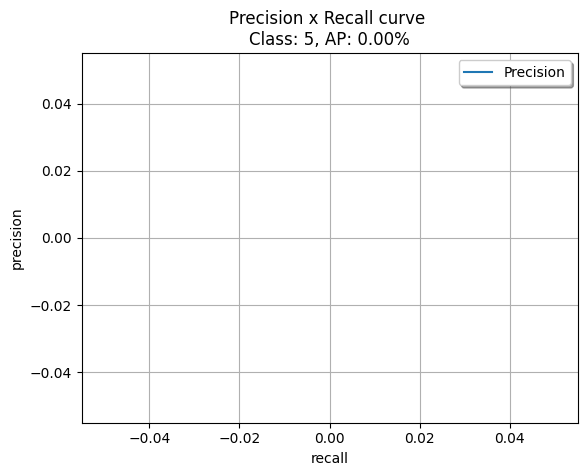

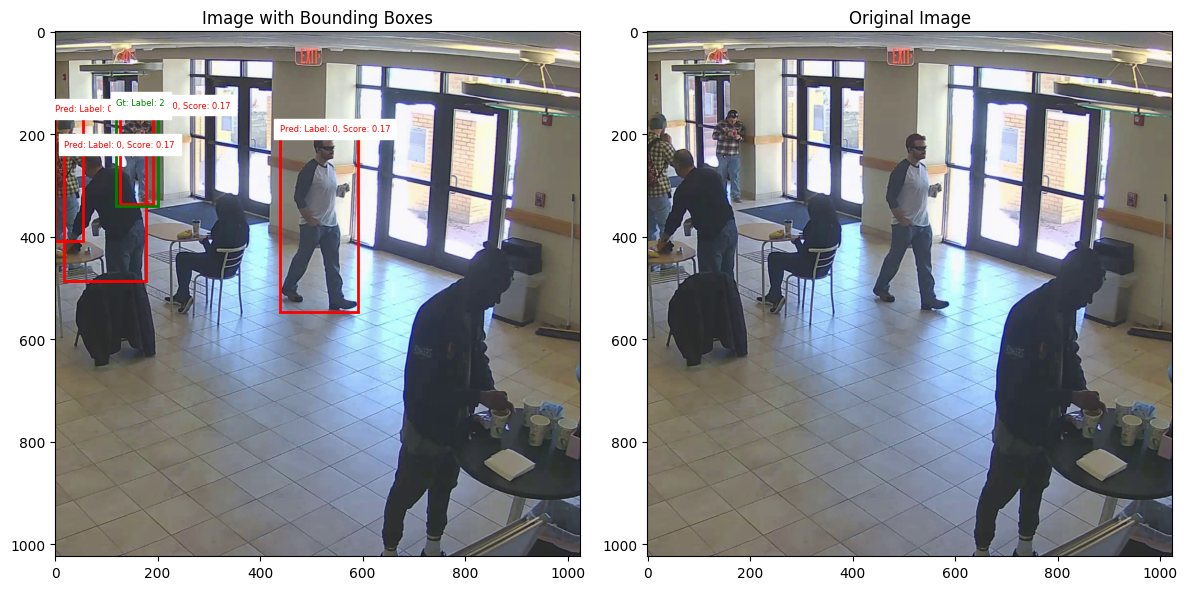

AP: 0.00% (2)
AP: 0.00% (3)
AP: 0.00% (5)
mAP: 0.00%
Detections example:
boxes=tensor([[  83.5770,  392.3797,  354.6378, 1022.5657],
        [ 619.9193,  316.8879,  770.6801,  554.9496],
        [ 151.7829,  164.3141,  254.2298,  441.2959]], device='cuda:0')
scores=tensor([0.1738, 0.1757, 0.1726], device='cuda:0')
labels=tensor([0, 0, 0], device='cuda:0')

loss={'loss': tensor(0.0579, device='cuda:0')}
Gt After Detector:
gt_boxes.bbox=tensor([[ 16.8917, 263.6375, 140.1136, 431.7542],
        [485.8990, 157.6094, 609.1208, 476.6490],
        [514.5552, 146.1469, 594.7927, 337.1885]])
gt_labels=tensor([[0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0]])


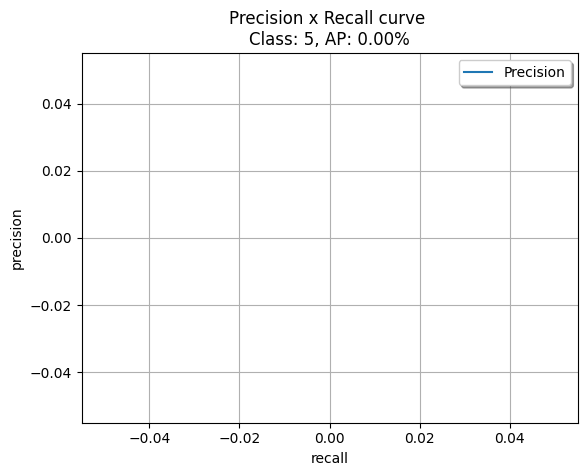

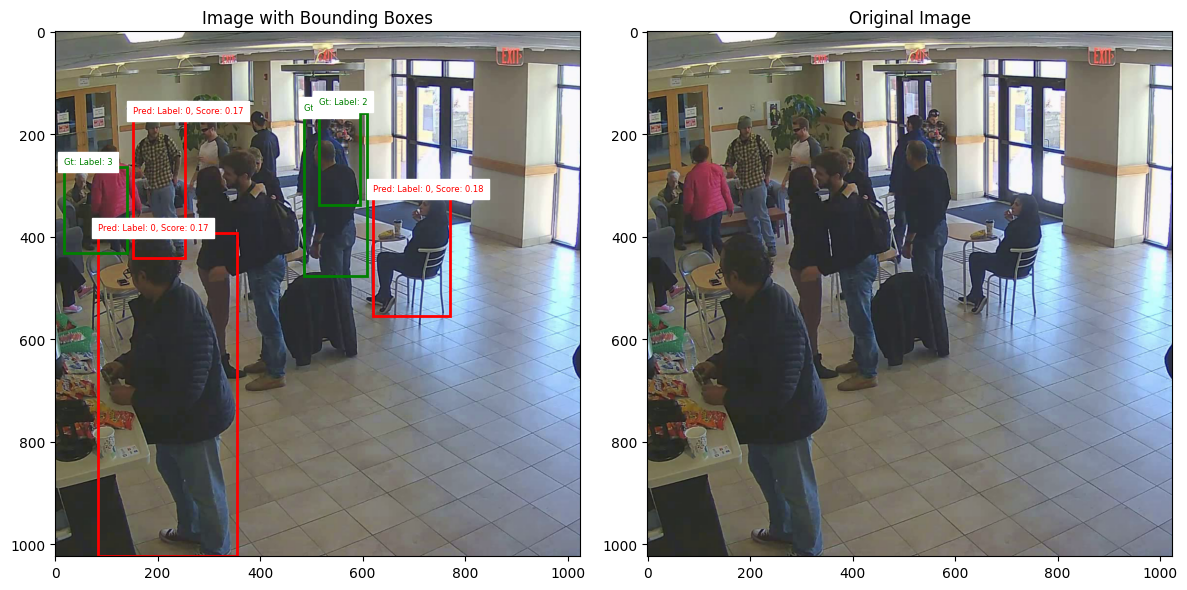

AP: 0.00% (2)
AP: 0.00% (3)
AP: 0.00% (5)
mAP: 0.00%
Detections example:
boxes=tensor([[ 322.0621,  146.0805,  400.4354,  339.1391],
        [   0.0000,  410.4331,  195.3512, 1022.2863],
        [ 947.8436,  250.7995, 1023.7523,  548.8827],
        [ 420.5958,  316.1357,  576.5499,  552.1552]], device='cuda:0')
scores=tensor([0.1728, 0.1744, 0.1744, 0.1750], device='cuda:0')
labels=tensor([0, 0, 0, 0], device='cuda:0')

loss={'loss': tensor(0.0579, device='cuda:0')}
Gt After Detector:
gt_boxes.bbox=tensor([[406.4792, 308.5323, 580.3271, 556.8865]])
gt_labels=tensor([[0, 0, 1, 0, 0, 0]])


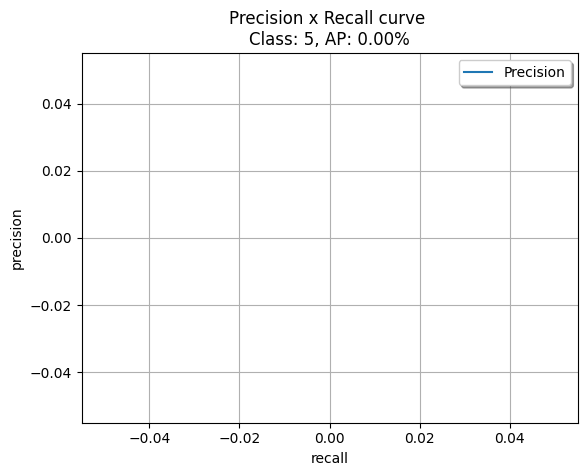

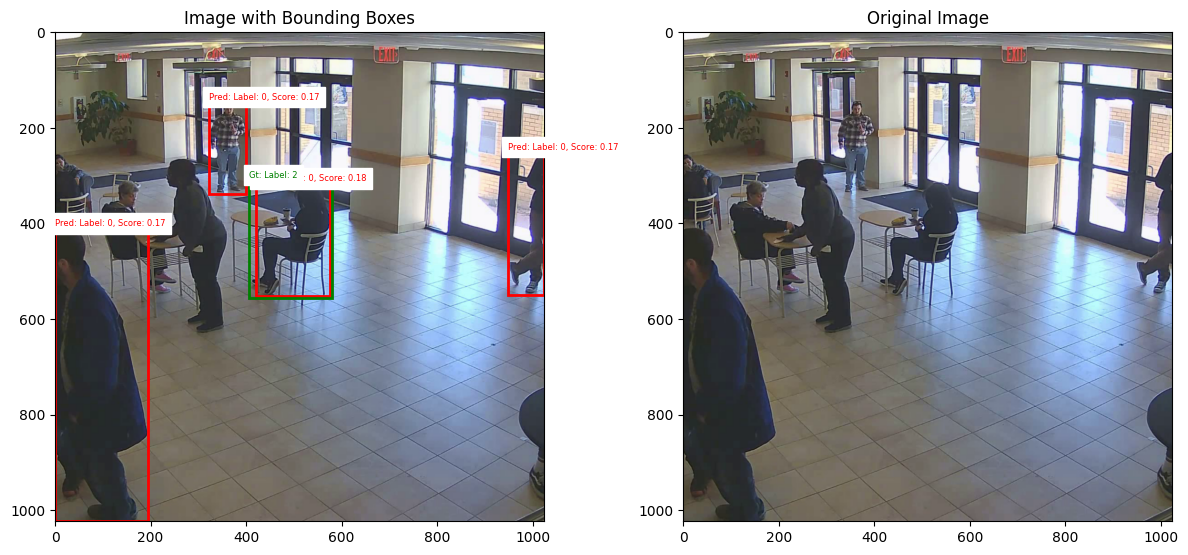

AP: 0.00% (2)
AP: 0.00% (3)
AP: 0.00% (5)
mAP: 0.00%
match rate: 0.5
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5425
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 3496


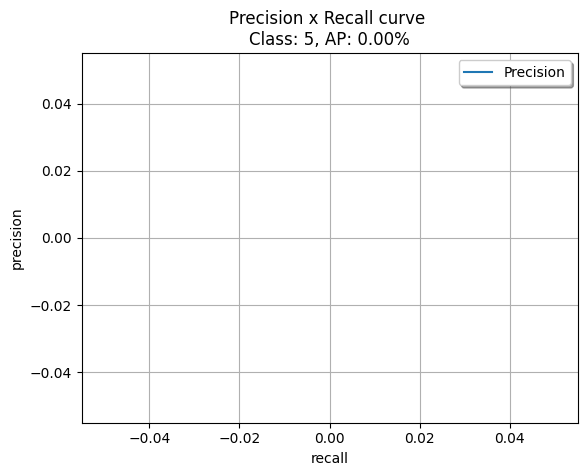

In [142]:
for i, x in enumerate(dataloaders['test']):
    if i == 1: break

    print(f"{x['video'].shape=}") # [b, c, t, h, w]
    print("-" * 10)
    print(f"{len(x['target'])=}") # List[b, (n, num_cls)]
    print(f"{x['target'][0].shape=}")
    print("-" * 10)
    print(f"{len(x['bbox'])=}") # List[b, BoxList[n]]
    print(f"{x['bbox'][bi].bbox.shape=}")
    print(f"{x['bbox'][bi].bbox=}")
    print("-" * 10)
    print(f"{len(x['path'])=}") # List[b]
    print(f"{x['path'][0]=}")

    batch_size = x['video'].shape[0]

    acc_AP = 0
    validClasses = 0

    model.eval()
    with torch.no_grad():

        detection_results, loss = detector(
            x['video'].to(device),
            [b.to(device) for b in x['bbox']],
            [l.to(device) for l in x['target']],
        )
        
        for batch_idx in range(batch_size):
            print_detections(detection_results[batch_idx])
            print(f"\n{loss=}")

            fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))
            batch_count, c, t, h, w = x['video'].shape
            middle_idx = t//2
            
            # [b, c, t, h, w] -> [c, h, w] -> uint8 -> [h, w, c]
            image = (
                x['video'].numpy()[batch_idx, :, middle_idx]
                .astype(np.uint8)
                .transpose((1, 2, 0))
                .copy())
            ax.imshow(image)
        
            # Plot 1: Just the image without bounding boxes
            ax1.imshow(image)
            ax1.set_title('Original Image')

            boxes = detection_results[batch_idx]['boxes'].cpu().detach().numpy()
            scores = detection_results[batch_idx]['scores'].cpu().detach().numpy()
            labels = detection_results[batch_idx]['labels'].cpu().detach().numpy()

            print(f"Gt After Detector:")
            gt_boxes = x['bbox'][batch_idx]
            print(f"{gt_boxes.bbox=}")
            gt_labels = x['target'][batch_idx]
            print(f"{gt_labels=}")

            for box, score, label in list(zip(
                boxes, scores, labels)):
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min

                rect = patches.Rectangle(
                    (x_min, y_min), width, height, 
                    linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                label_text = f"Pred: Label: {label}, Score: {score:.2f}"
                ax.text(x_min, y_min - 5, label_text, color='red', fontsize=6, backgroundcolor='white')

            for bbox_i in range(len(gt_boxes)):
                gt_boxes_size = gt_boxes.size
                x_min, y_min, x_max, y_max = gt_boxes.bbox[bbox_i]
                width = x_max - x_min
                height = y_max - y_min

                rect = patches.Rectangle(
                    (x_min, y_min), width, height, 
                    linewidth=2, edgecolor='g', facecolor='none')
                ax.add_patch(rect)

                label_text = f"Gt: Label: {np.argmax(gt_labels[bbox_i])}"
                ax.text(x_min, y_min - 5, label_text, color='green', fontsize=6, backgroundcolor='white')

            ax.set_title('Image with Bounding Boxes')

            plt.tight_layout()
            plt.show()

            detections = compute_metrics_batch_detections(detection_results, x, savePath)

            f = open(os.path.join(savePath, 'results.txt'), 'w')
            f.write('Object Detection Metrics\n')
            f.write('https://github.com/rafaelpadilla/Object-Detection-Metrics\n\n\n')
            f.write('Average Precision (AP), Precision and Recall per class:')

            # each detection is a class
            for metricsPerClass in detections:

                # Get metric values per each class
                cl = metricsPerClass['class']
                ap = metricsPerClass['AP']
                precision = metricsPerClass['precision']
                recall = metricsPerClass['recall']
                totalPositives = metricsPerClass['total positives']
                total_TP = metricsPerClass['total TP']
                total_FP = metricsPerClass['total FP']

                if totalPositives > 0:
                    validClasses = validClasses + 1
                    acc_AP = acc_AP + ap
                    prec = ['%.2f' % p for p in precision]
                    rec = ['%.2f' % r for r in recall]
                    ap_str = "{0:.2f}%".format(ap * 100)
                    # ap_str = "{0:.4f}%".format(ap * 100)
                    print('AP: %s (%s)' % (ap_str, cl))
                    f.write('\n\nClass: %s' % cl)
                    f.write('\nAP: %s' % ap_str)
                    f.write('\nPrecision: %s' % prec)
                    f.write('\nRecall: %s' % rec)

            mAP = acc_AP / validClasses
            mAP_str = "{0:.2f}%".format(mAP * 100)
            print('mAP: %s' % mAP_str)
            f.write('\n\n\nmAP: %s' % mAP_str)
            
        print(f'match rate: {detector.get_match_rate()}')

In [143]:
detector.get_match_rate()

0.5

In [144]:
batch_count = len(detection_results)
print(f"{batch_count=}")
first = detection_results[0]
print(f"{first.keys()=}")
print(f"{first['boxes'].shape=}")
print(f"{first['scores'].shape=}")
print(f"{first['labels'].shape=}")
print(f"{first['labels'].unique()=}")

batch_count=4
first.keys()=dict_keys(['boxes', 'scores', 'labels'])
first['boxes'].shape=torch.Size([4, 4])
first['scores'].shape=torch.Size([4])
first['labels'].shape=torch.Size([4])
first['labels'].unique()=tensor([0], device='cuda:0')


# Train script

In [145]:
def draw_bboxes_all_batch(data_index, batch, detection_results, top_k=3):
    batch_len = len(batch['bbox'])
    # Create a figure with 1 row and batch_len columns
    fig, axes = plt.subplots(1, batch_len, figsize=(5*batch_len, 5))
    
    # If there's only one image, axes won't be an array
    if batch_len == 1:
        axes = [axes]
    
    # Remove gaps between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    
    batch_count, c, t, h, w = x['video'].shape
    
    for batch_i, ax in enumerate(axes):
        video = batch['video'][batch_i].detach().clone()
        middle_frame_index = t//2
        
        # [c, h, w] -> [h, w, c]
        image = video[:, middle_frame_index].permute(1, 2, 0)
        image = (image - image.min()) / (image.max() - image.min())

        ax.imshow(image)
        ax.axis('off')  # Turn off axes
        
        # Detection results (red boxes)
        boxes = detection_results[batch_i]['boxes'].cpu().detach().numpy()
        scores = detection_results[batch_i]['scores'].cpu().detach().numpy()
        labels = detection_results[batch_i]['labels'].cpu().detach().numpy()
        
        gt_boxes = batch['bbox'][batch_i]
        gt_labels = batch['target'][batch_i]

        for box, score, label in list(zip(boxes, scores, labels)):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            label_text = f"Label: {label}, Score: {score:.2f}"
            ax.text(x_min, y_min - 5, label_text,
                    color='red', fontsize=6, backgroundcolor='white')
        
        # Ground truth boxes (green boxes)
        for bbox_i in range(len(gt_boxes)):
            x_min, y_min, x_max, y_max = gt_boxes.bbox[bbox_i]
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle(
                (x_min, y_min), width, height, 
                linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

            label_text = f"Gt: Label: {np.argmax(gt_labels[bbox_i])}"
            ax.text(x_min, y_min - 5, label_text, 
                    color='green', fontsize=6, backgroundcolor='white')

    fname, ext = os.path.splitext(bboxes_path)
    plt.savefig(f"{fname}_{data_index}{ext}", bbox_inches='tight', pad_inches=0)
    plt.clf()

def draw_bboxes(batch, boxes, scores, labels, top_k=3):
    # video shape - [c, t, h, w]
    # boxes shape - [n, 4]
    # labels and scores shape - [n]
    
    video = batch['video'][bi]

    fig, ax = plt.subplots(1)
    middle_frame_index = video.shape[1] // 2
    # [c, h, w] -> [c, w, h]
    image = video[:, middle_frame_index].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    ax.imshow(image)

    # print(f"top_k boxes stat:\n{list(zip(boxes, scores, labels))[:top_k]}")

    for box, score, label in list(zip(boxes, scores, labels))[:top_k]:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height,
                                  linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        label_text = f"Label: {label}, Score: {score:.2f}"
        ax.text(x_min, y_min - 5, label_text,
                color='red', fontsize=6, backgroundcolor='white')
        
    for bbox_i in range(len(batch['bbox'][bi])):
        x_min, y_min, x_max, y_max = batch['bbox'][bi].bbox[bbox_i]
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle(
            (x_min, y_min), width, height, 
            linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

        label_text = f"Gt: Label: {np.argmax(batch['target'][bi][bbox_i])}"
        ax.text(x_min, y_min - 5, label_text, 
                color='green', fontsize=6, backgroundcolor='white')

    plt.savefig(bboxes_path)
    plt.clf()

In [146]:
def run_epoch(phase, dataloader):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_mAP = 0.0
    running_AP = {f"AP-{i}": 0.0 for i in range(num_classes)}

    all_elems_count = 0
    batch_count = len(dataloader)

    cur_tqdm = tqdm(dataloader, total=len(dataloader), leave=False)
    for i, batch in enumerate(cur_tqdm):
        acc_AP = 0
        validClasses = 0

        inputs = batch['video'].to(device) # [B, C, T, H, W]
        labels = [l.to(device) for l in batch['target']] # List[B, (N, cls)]
        boxes = [b.to(device) for b in batch['bbox']]
        
        detection_results, losses = detector(inputs, boxes, labels)

        bz = inputs.shape[0]
        all_elems_count += bz

        show_dict = {}

        if phase == 'train':
            loss = sum(losses.values())

            if isinstance(loss, int):
                print(f"{inputs.shape[0]=}")
                print(f'{loss=} {losses.values()=}')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * bz

            show_dict['Loss'] = f'{loss.item():.6f}'
            for k, v in losses.items(): show_dict[k] = v.item()
            cur_tqdm.set_postfix(show_dict)

            # if i % evaluation_step == 0 and i != 0:
            #     test_epoch(dataloaders['test']) # note: after return model in eval mode not train

        elif phase == 'test':
            draw_bboxes_all_batch(i, batch, detection_results)

            detection_metrics = compute_metrics_batch_detections(
                detection_results, batch, savePath
            )

            show_dict['bbox_num_per_video'] = sum(
                r['boxes'].shape[0] 
                for r in detection_results) / bz
            
            show_dict['labels_in_batch'] = set(np.concatenate(
                [label.cpu().detach().argmax(dim=1).squeeze().numpy()
                 for label in labels], axis=None))
            
            show_dict['pred_labels'] = set(np.concatenate(
                [r['labels'].cpu().detach().numpy()
                 for r in detection_results]))

            for metricsPerClass in detection_metrics:
                cl = metricsPerClass['class']
                ap = metricsPerClass['AP']
                totalPositives = metricsPerClass['total positives']
                total_TP = metricsPerClass['total TP']
                total_FP = metricsPerClass['total FP']

                if totalPositives > 0:
                    validClasses = validClasses + 1
                    acc_AP = acc_AP + ap

                    show_dict[f'AP-{cl}'] = "{0:.2f}%".format(ap * 100)
                    running_AP[f'AP-{cl}'] += ap

                    # show_dict[f'total_TP-{cl}'] = total_TP
                    # show_dict[f'total_FP-{cl}'] = total_FP
                    # show_dict[f'total_Positives-{cl}'] = totalPositives

            if validClasses != 0:
                mAP = acc_AP / validClasses
                show_dict['mAP'] = "{0:.2f}%".format(mAP * 100)
                running_mAP += mAP

            cur_tqdm.set_postfix(show_dict)

    epoch_loss = running_loss / batch_count
    epoch_mAP = running_mAP / batch_count
    epoch_AP = {k: v / batch_count for k, v in running_AP.items()}
    epoch_match_rate = detector.get_match_rate()

    gc.collect()

    return epoch_loss, epoch_mAP, epoch_AP, epoch_match_rate

In [147]:
def test_epoch(dataloader):
    with torch.inference_mode():
        return run_epoch('test', dataloader)

def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [148]:
def plot_losses_and_metrics(losses, mAPs, rates):
    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

    # Plot Loss
    ax1.plot(losses, label='Training Loss', color='red', marker='o')
    ax1.set_title('Training Loss Over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot mAP
    ax2.plot(mAPs, label='mAP Score', color='blue', marker='s')
    ax2.set_title('mAP Over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('mAP')
    ax2.legend()
    ax2.grid(True)
    
    # Plot mAP
    ax3.plot(rates, label='Match rate', color='blue', marker='s')
    ax3.set_title('Rate Over Epochs')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Match Rate')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

In [149]:
def train_model(dataloaders, writer=None, num_epochs=5):
    print(f"Training model with params:")
    print(f"Optim: {optimizer}")
    print(f"Criterion: {criterion}")

    phases = ['train', 'test']
    for phase in dataloaders:
        if phase not in phases:
            phases.append(phase)
            
    rates = []
    losses = []
    mAPs = []

    for epoch in tqdm(range(start_epoch, num_epochs + 1)):
        for phase in phases:

            epoch_loss, epoch_mAP, epoch_AP, epoch_match_rate = train_epoch(dataloaders[phase]) if phase == 'train' \
                    else test_epoch(dataloaders[phase])

            if writer:
                if phase == 'train':
                    losses.append(epoch_loss)
                    writer.add_scalar(f'loss/{phase}', epoch_loss, epoch)

                    rates.append(epoch_match_rate)

                elif phase == 'test':
                    mAPs.append(epoch_mAP)
                    writer.add_scalar(f'mAP/{phase}', epoch_mAP, epoch)

                    precision_recall_curves = {
                        f'images/{i}-curve': os.path.join(savePath, f'{i}.png')
                        for i in range(5)
                    }
                    
                    fname, ext = os.path.splitext(bboxes_path)
                    image_paths = {
                        'images/bboxes': f"{fname}_0{ext}",
                        **precision_recall_curves
                    }

                    for k, path in image_paths.items():
                        if os.path.exists(path):
                            writer.add_image(k, plt.imread(path)[:, :, :3], epoch, dataformats='HWC')

                    for k, v in epoch_AP.items():
                        writer.add_scalar(f'{k}/{phase}', v, epoch)
        
        plot_losses_and_metrics(losses, mAPs, rates)

        if epoch % save_frequency == 0:
            model_path = f"{system_root}/runs/{run_name}/{exp_name}.pth"
            print(f"Saving model at {model_path}")
            torch.save({'epoch': epoch,
                        'model': model.state_dict()}, model_path)

            repo_name = f"{exp_name}-{seed}"
            os.system(f"zip -r {system_root}/{repo_name}.zip runs")
            # os.system(f"cp {repo_name}.zip /content/drive/MyDrive/data")

# Train model

In [158]:
%ls -la /kaggle/input/yolovideomae_pretrained_15_localization_finetuning/pytorch/default/1/runs/AL_YOLO_VideoMAE_MEVA_talksOnPhone_10ep_4bs_16cliplen-2fsr-15__2025__21.05.2025_07-12/

total 722776
drwxr-xr-x 2 nobody nogroup         0 May 23 10:49 ./
drwxr-xr-x 3 nobody nogroup         0 May 23 10:49 ../
-rw-r--r-- 1 nobody nogroup 345770394 May 23 10:51 AL_YOLO_VideoMAE_MEVA_talksOnPhone_10ep_4bs_16cliplen-2fsr-15.pth
-rw-r--r-- 1 nobody nogroup 345770394 May 23 10:51 AL_YOLO_VideoMAE_MEVA_talksOnPhone_50ep_4bs_16cliplen-2fsr-15.pth
-rw-r--r-- 1 nobody nogroup  48578554 May 23 10:50 events.out.tfevents.1747811529.8395d243c511.64.0


In [159]:
load_checkpoint = None
# load_checkpoint = f'{system_root}/runs/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-2fsr-11i13__2025__25.04.2025_13-56/AL_VideoMAE_MEVA_talksOnPhone_15ep_4bs_16cliplen-2fsr-11i13.pth'
load_checkpoint = '/kaggle/input/yolovideomae_pretrained_15_localization_finetuning/pytorch/default/1/runs/AL_YOLO_VideoMAE_MEVA_talksOnPhone_10ep_4bs_16cliplen-2fsr-15__2025__21.05.2025_07-12/AL_YOLO_VideoMAE_MEVA_talksOnPhone_50ep_4bs_16cliplen-2fsr-15.pth'
start_epoch = 0
if load_checkpoint is not None:
    checkpoint = torch.load(load_checkpoint, weights_only=True, map_location=device)
    if isinstance(model, nn.DataParallel):
        model.load_state_dict(
            {f"module.{k}": v for k, v in checkpoint['model'].items()})
    else:
        model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint['epoch'] + 1

In [180]:
start_epoch

69

In [161]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [162]:
%ls -la /kaggle/working/runs

ls: cannot access '/kaggle/working/runs': No such file or directory


In [96]:
!rm -rf /kaggle/working/runs

In [163]:
!mkdir /kaggle/working/runs

In [81]:
%reload_ext tensorboard
%tensorboard --logdir /kaggle/working/runs

Reusing TensorBoard on port 6006 (pid 202), started 0:00:02 ago. (Use '!kill 202' to kill it.)

<IPython.core.display.Javascript object>

In [164]:
from datetime import datetime
current_time = datetime.now().strftime("%d.%m.%Y_%H-%M")
run_name = f"{exp_name}__{seed}__{current_time}"
log_dir = f"{system_root}/runs/{run_name}"
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [165]:
os.makedirs(log_dir, exist_ok=True)
log_dir

'/kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03'

In [166]:
os.getcwd()

'/kaggle/working/IndustrialMotionDetection/notebooks'

In [167]:
import warnings
warnings.filterwarnings("ignore")

In [168]:
import gc
gc.collect()
# torch.cuda.empty_cache()

90860

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: FocalLoss()


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-05-00.15-10-00.school.G421_frange0-9000.avi at 7745
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi at 2584
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-50-00.15-54-59.school.G421_frange0-9001.avi at 5366
INFO: 6 annots for 2018-03-15/15/2018-03-15.15-05-00.15-10-00.bus.G331_frange0-9008.avi at 6586
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 10 proposals for image #0
gt_target_dict['bbox']=tensor([[109.2164,  66.0288, 148.7083, 132.0576],
        [ 53.0084,  72.2973,  96.4703, 134.3560],
        [171.0661,  59.7602, 207.2148, 123.2816],
        [ 28.7700,  70.8347,  67.6350, 103.2222]], device='cuda:0')
gt_target_dict['target']=tensor([3, 3, 5, 2], device='cuda:0')
bboxes.bbox=tensor([[ 33.6881, 134.9152,  94.0145, 223.9363],
        [ 61.8102,  79.3067, 102.4083, 144.1277],
        [155.5014,  59.7915, 180.8970, 117.5656],
   

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 6 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G331_frange0-4404.avi at 4149
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 7868
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 8 proposals for image #0
gt_target_dict['bbox']=tensor([[141.3923,  98.4945, 203.8066, 191.3903],
        [ 70.8910,  45.6185, 101.7871,  84.8089],
        [166.8971,  33.7992, 191.3652,  73.8190]], device='cuda:0')
gt_target_dict['target']=tensor([4, 2, 2], device='cuda:0')
bboxes.bbox=tensor([[ 92.6970, 109.2615, 152.4321, 223.9466],
        [172.5087,  43.7763, 209.0664, 127.3275],
        [139.7219,  46.1815, 165.7343,  88.1559],
        [168.5012,  35.6492, 189.2997,  69.7659],
        [144.8581, 102.7035, 197.8818, 148.0862],
        [ 74.2299,  47.7451,  99.5594,  82.1331],
        [216.0716,  78.2486, 223.9174, 138.6571],
        [189.9869,  35.3861, 201.5981,  47.2120]], devi

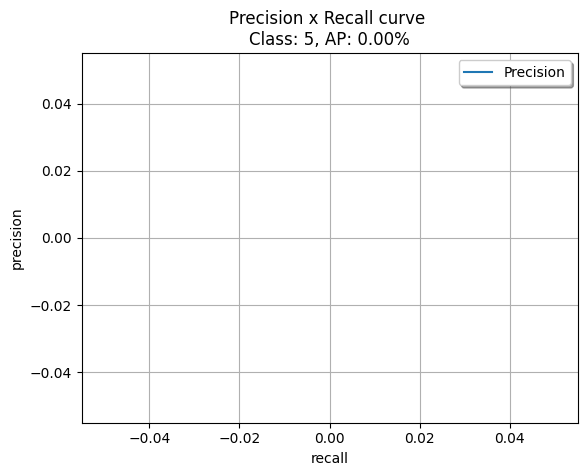

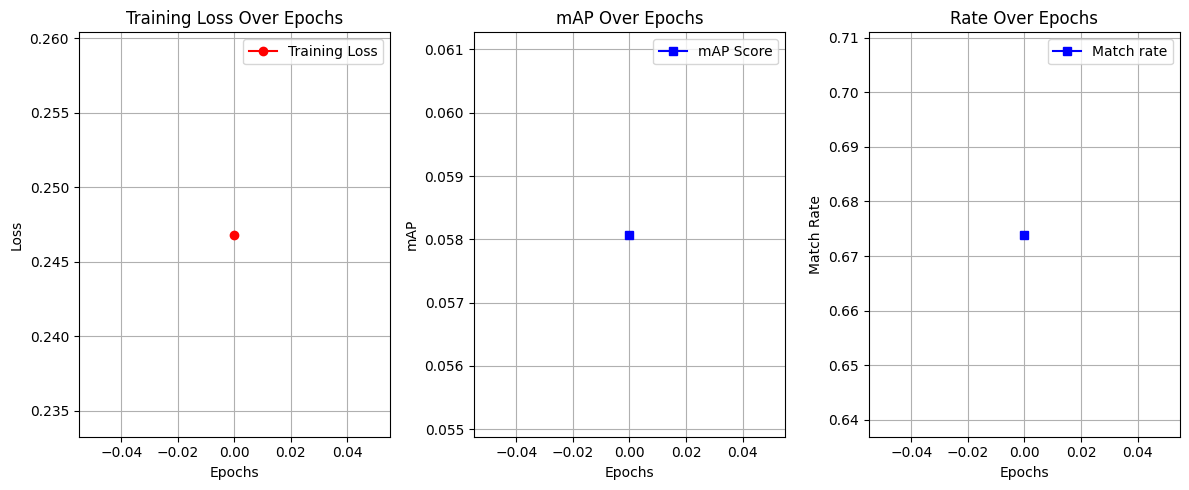

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 3 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 6978
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-50-00.15-54-59.school.G421_frange0-9001.avi at 8629
INFO: 2 annots for 2018-03-15/15/2018-03-15.14-55-01.15-00-01.bus.G506_frange0-9001.avi at 66
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 6978
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 4 proposals for image #0
gt_target_dict['bbox']=tensor([[ 49.7253,  67.7004,  99.2469, 122.8637]], device='cuda:0')
gt_target_dict['target']=tensor([2], device='cuda:0')
bboxes.bbox=tensor([[9.8612e+01, 3.2540e+01, 1.1715e+02, 9.0350e+01],
        [5.5608e+01, 6.9885e+01, 9.7089e+01, 1.2067e+02],
        [4.0485e+01, 5.9804e+01, 6.2900e+01, 9.6568e+01],
        [4.1051e-02, 6.5971e+01, 2.4036e+01, 1.2180e+02]], device='cuda:0')
Matching info:
idxs_true=array([0])
idxs_pred.tolist()=[1]
ious=a

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 3 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 4807
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 832
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 2632
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 820
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 13 proposals for image #0
gt_target_dict['bbox']=tensor([[ 39.3513,  57.6707,  66.3061,  94.4462],
        [142.1556,  34.6860, 169.1104, 104.2670],
        [148.2152,  31.9696, 165.7672,  73.7600]], device='cuda:0')
gt_target_dict['target']=tensor([3, 5, 2], device='cuda:0')
bboxes.bbox=tensor([[ 53.8569,  86.1479, 113.3732, 223.9180],
        [ 97.0632,  54.3183, 139.0216, 153.6173],
        [170.7429,  69.2993, 204.1941, 121.3463],
        [ 70.3164,  36.0353,  91.5829,  96.7113],
     

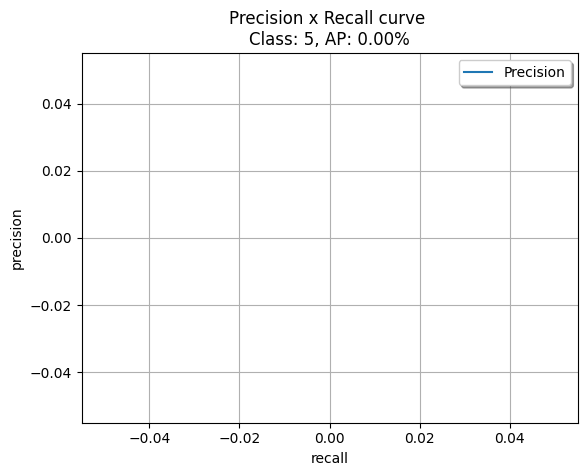

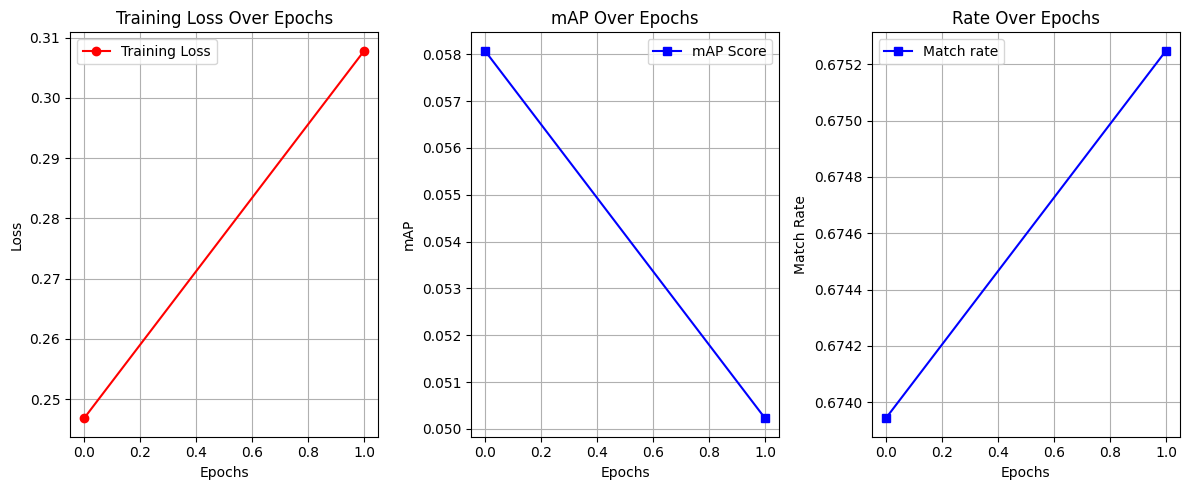

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 3 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi at 8347
INFO: 2 annots for 2018-03-15/14/2018-03-15.14-50-00.14-55-00.bus.G331_frange2684-9008.avi at 1763
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-05-01.15-10-01.bus.G506_frange0-8033.avi at 6658
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.bus.G331_frange7399-9007.avi at 659
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 7 proposals for image #0
gt_target_dict['bbox']=tensor([[ 75.3715,  57.6707, 113.1917, 118.8936]], device='cuda:0')
gt_target_dict['target']=tensor([2], device='cuda:0')
bboxes.bbox=tensor([[5.2778e-02, 1.5648e+02, 4.1933e+01, 2.2384e+02],
        [1.0061e+02, 8.0667e+01, 1.4390e+02, 2.0110e+02],
        [2.3033e+01, 4.7528e+01, 4.1607e+01, 8.8444e+01],
        [7.5870e+01, 5.9496e+01, 9.7862e+01, 1.1833e+02],
        [4.2413e+00, 5.6537e+01, 2.4848e+01, 9.5135e+01],
        [0.0000e+00, 5.5

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5373
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5258
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 3347
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 8 proposals for image #0
gt_target_dict['bbox']=tensor([[ 33.4744,  57.8797,  60.4292,  94.6552],
        [ 29.9223,  56.6259,  70.0410, 126.2069],
        [ 66.4888,  54.9543,  88.0109,  88.3866],
        [143.1742,  32.1786, 160.7261,  73.9689]], device='cuda:0')
gt_target_dict['target']=tensor([3, 5, 1, 2], device='cuda:0')
bboxes.bbox=tensor([[ 47.4616,  82.8653, 106.3829, 223.4966],
        [141.1271,  37.9713, 166.8331, 107.6697],
        [ 15.2294,  72.6523,  33.5834,  88.1637],
        [166.9149,  69.1413, 199.1915, 120.6565],
        [ 78.9327,  49.6464, 108.6693, 132.6094],


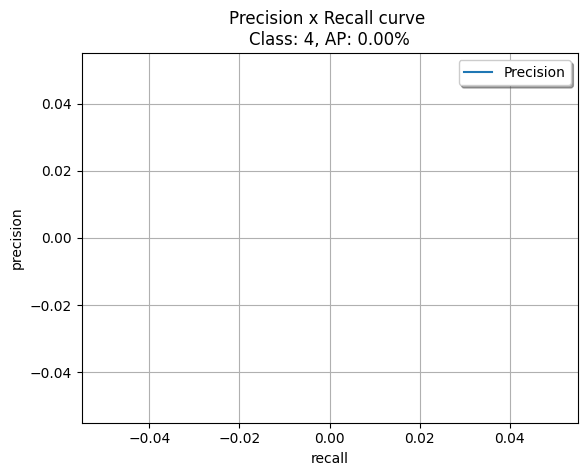

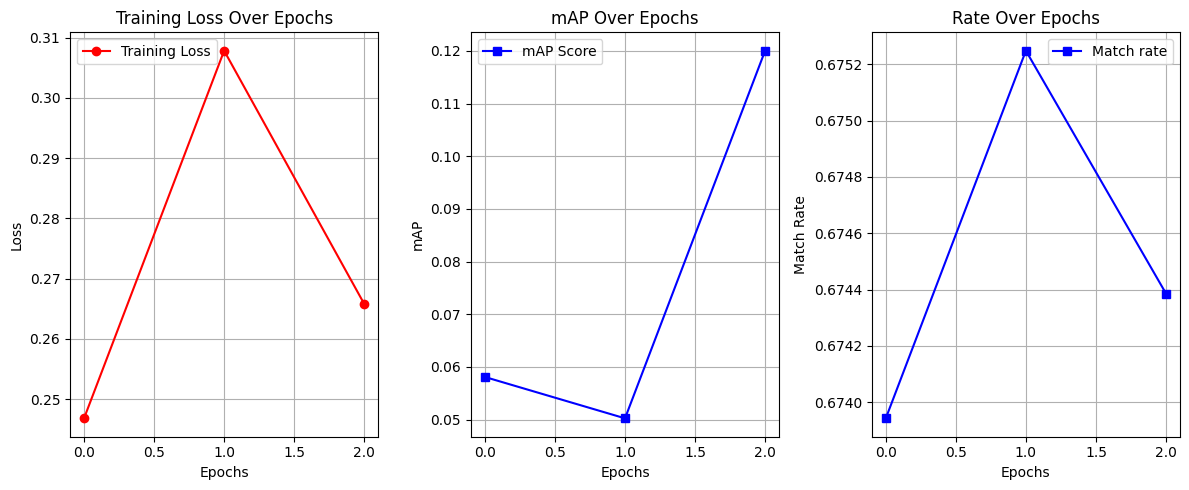

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 2 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 4193
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 3743
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi at 1084
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-50-00.15-54-59.school.G421_frange0-9001.avi at 3692
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 10 proposals for image #0
gt_target_dict['bbox']=tensor([[ 54.0237,  85.4613, 125.2763, 223.7812],
        [172.2905,  67.9093, 211.7824, 123.9084]], device='cuda:0')
gt_target_dict['target']=tensor([5, 2], device='cuda:0')
bboxes.bbox=tensor([[5.3553e-02, 1.2355e+02, 5.3693e+01, 2.2390e+02],
        [1.8080e+02, 6.7199e+01, 2.2219e+02, 1.9549e+02],
        [1.0236e+02, 5.2493e+01, 1.2262e+02, 9.2103e+01],
        [6.9556e+01, 8.4297e+01, 1.2536e+02, 2.2393e+02],
        [5.9219e+01, 7.1

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 3 annots for 2018-03-15/15/2018-03-15.15-15-00.15-20-00.bus.G508_frange0-4675.avi at 2882
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5442
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5338
INFO: 2 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 4903
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 3 proposals for image #0
gt_target_dict['bbox']=tensor([[ 27.2701,  91.3120,  52.1354, 168.6241],
        [  0.0000, 162.1466,  59.2398, 223.7812]], device='cuda:0')
gt_target_dict['target']=tensor([2, 2], device='cuda:0')
bboxes.bbox=tensor([[  0.7847, 163.7408,  59.3922, 220.1125],
        [ 26.3350, 175.9127,  73.9692, 223.9463],
        [ 30.2721,  92.8346,  50.8472, 164.9792]], device='cuda:0')
Matching info:
idxs_true=array([0, 1])
idxs_pred.tolist()=[2, 0]
ious=array([    0.77909,   

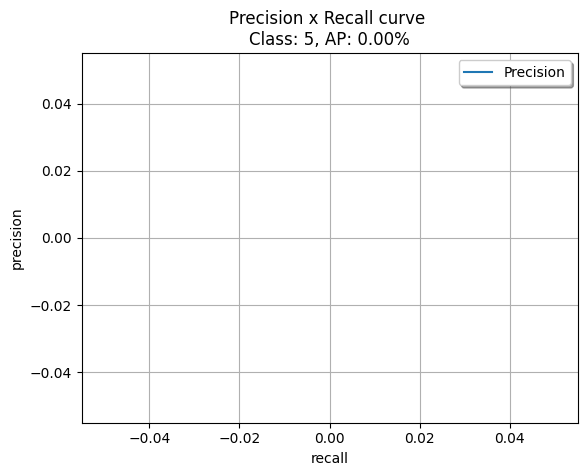

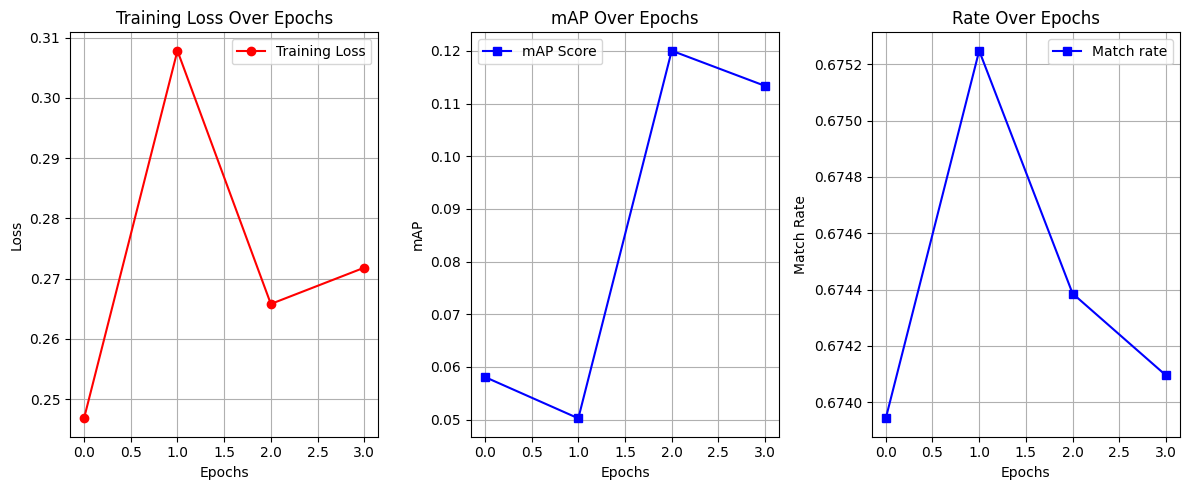

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 5505
INFO: 2 annots for 2018-03-15/15/2018-03-15.14-55-01.15-00-01.bus.G506_frange0-9001.avi at 8241
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 2936
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-50-00.15-54-59.school.G421_frange0-9001.avi at 1748
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 10 proposals for image #0
gt_target_dict['bbox']=tensor([[ 49.0253,  58.0886,  75.1443,  96.1178],
        [ 98.9648,  41.9993, 133.4418,  98.8342],
        [ 82.8755,  54.3275, 105.2333,  90.4761],
        [177.1128,  67.4914, 217.2315, 123.0726]], device='cuda:0')
gt_target_dict['target']=tensor([3, 5, 1, 2], device='cuda:0')
bboxes.bbox=tensor([[  3.0977, 133.3963,  59.6767, 223.8373],
        [180.2961,  69.4961, 214.7271, 120.0058],
        [ 44.8423,  65.8081,  62.2934,  92.5465],
   

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5134
INFO: 6 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.bus.G331_frange0-4404.avi at 4245
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 7941
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 11 proposals for image #0
gt_target_dict['bbox']=tensor([[ 22.9842,  58.0886,  49.9390,  94.8641],
        [ 22.9842,  54.7454,  66.4462, 128.2964],
        [132.0571,  32.8054, 149.6091,  74.5958],
        [151.6986,  67.7004, 190.5636, 122.0279]], device='cuda:0')
gt_target_dict['target']=tensor([3, 5, 2, 2], device='cuda:0')
bboxes.bbox=tensor([[ 33.8552,  88.5273,  97.9235, 223.3827],
        [133.9793,  33.5134, 147.9887,  59.6517],
        [155.9505,  69.0779, 189.2018, 120.7963],
        [116.0357,  32.1693, 137.5343,  93.4937],
        [ 62.0589,  55.7940,  81.9343,  75.5500],
  

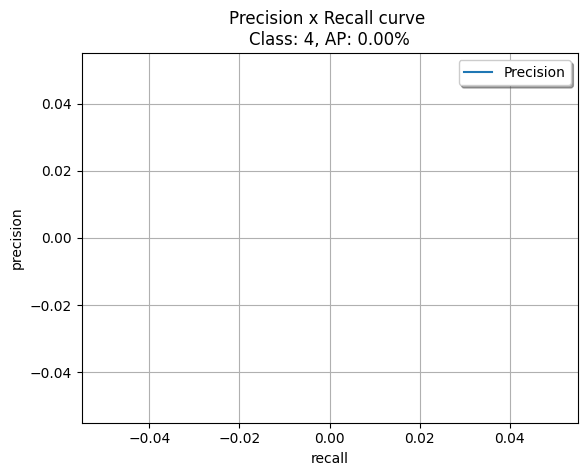

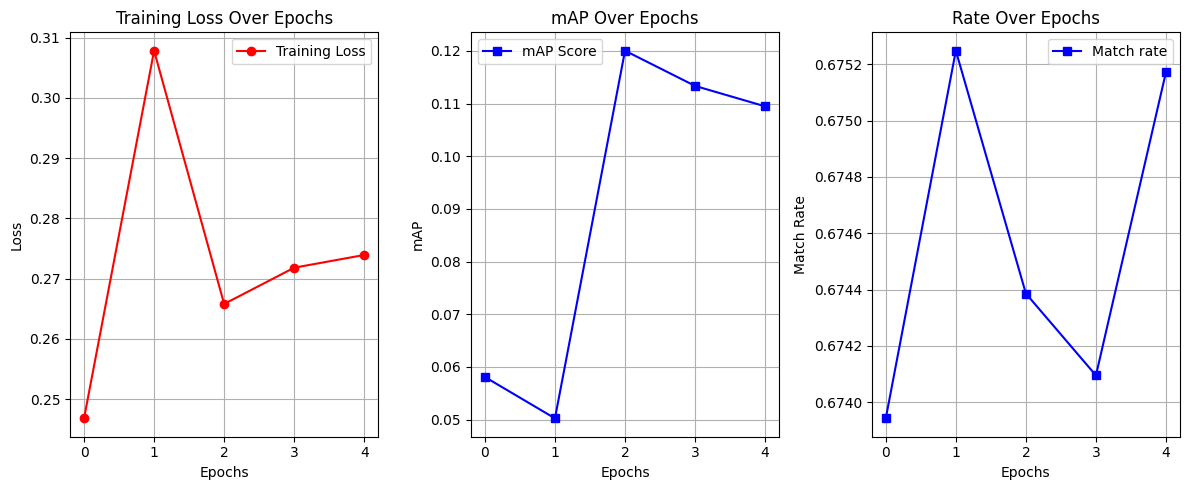

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 6 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 104
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-10-00.15-15-00.bus.G331_frange6242-9009.avi at 1337
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 6366
INFO: 7 annots for 2018-03-15/15/2018-03-15.15-10-00.15-15-00.bus.G331_frange0-5802.avi at 5055
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 8 proposals for image #0
gt_target_dict['bbox']=tensor([[ 35.0253,  57.8797,  61.3532,  95.9089],
        [ 54.2489,  91.3120, 133.0237, 223.7812],
        [ 93.9497,  68.3272, 131.9789, 120.9831],
        [ 68.6665,  54.9543,  91.6512,  90.4761],
        [163.3217,  67.7004, 202.8136, 122.0279]], device='cuda:0')
gt_target_dict['target']=tensor([3, 5, 4, 1, 2], device='cuda:0')
bboxes.bbox=tensor([[1.3240e+02, 8.3149e+01, 1.8187e+02, 2.0721e+02],
        [7.9101e+01, 9.3554e+01, 1.4164e+02,

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 5256
INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 819
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 1266
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 7 proposals for image #0
gt_target_dict['bbox']=tensor([[ 27.2761,  50.5663,  71.9918, 136.6545],
        [ 61.1263,  67.4914,  99.3645, 121.8189]], device='cuda:0')
gt_target_dict['target']=tensor([5, 2], device='cuda:0')
bboxes.bbox=tensor([[2.7492e+01, 5.2300e+01, 7.0253e+01, 1.3578e+02],
        [1.6465e+02, 8.8991e+01, 2.1277e+02, 2.2378e+02],
        [3.6148e+01, 3.1395e+01, 5.5269e+01, 6.1071e+01],
        [6.6241e+01, 6.9560e+01, 9.8291e+01, 1.2090e+02],
        [4.7725e-02, 1.2636e+02, 8.6572e+00, 2.2364e+02],
        [4.8027e+01, 3.2181e+01, 5.7444e+01, 4.8336e+01],
        [

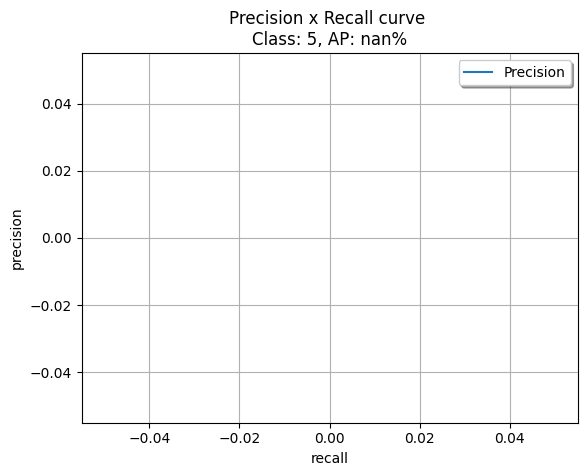

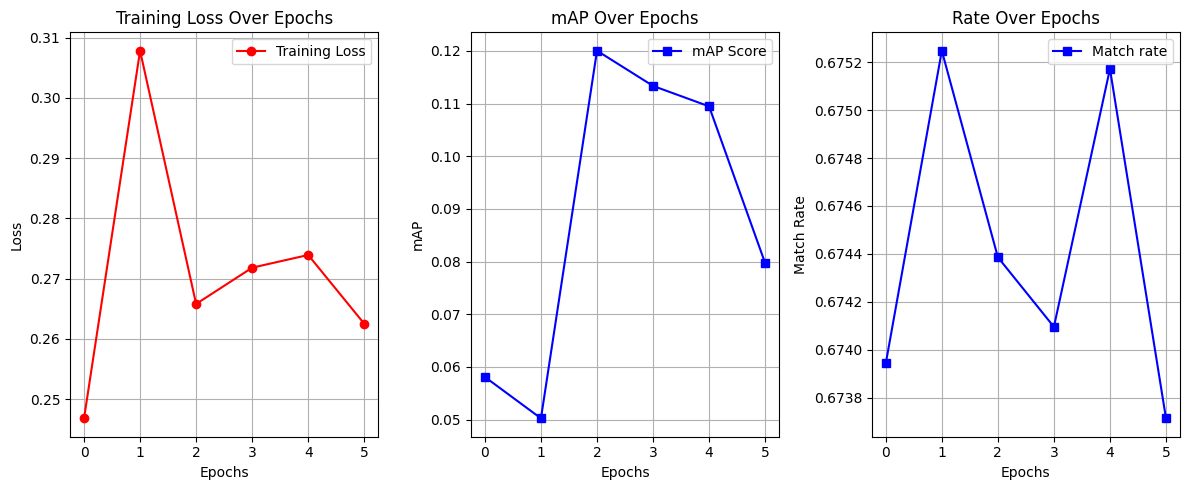

Saving model at /kaggle/working/runs/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15__2025__23.05.2025_12-03/AL_YOLO_VideoMAE_pretrained_MEVA_talksOnPhone_100ep_4bs_16cliplen-2fsr-15.pth


  0%|          | 0/26 [00:00<?, ?it/s]

INFO: 4 annots for 2018-03-15/15/2018-03-15.15-45-00.15-50-00.school.G421_frange0-9000.avi at 3616
INFO: 3 annots for 2018-03-15/15/2018-03-15.15-35-00.15-40-00.bus.G508_frange3195-6826.avi at 1440
INFO: 4 annots for 2018-03-15/15/2018-03-15.15-00-00.15-05-00.school.G421_frange0-9002.avi at 4079
x.shape=torch.Size([4, 3, 16, 1024, 1024])
target_size: (1024, 1024)
YOLO model output: len(results)=4
Gathered 7 proposals for image #0
gt_target_dict['bbox']=tensor([[ 28.3530,  67.9093,  67.6359, 124.1174]], device='cuda:0')
gt_target_dict['target']=tensor([2], device='cuda:0')
bboxes.bbox=tensor([[3.0591e+01, 6.7628e+01, 8.7213e+01, 1.8802e+02],
        [9.6832e+01, 1.5365e+02, 1.8768e+02, 2.2384e+02],
        [1.9915e+02, 5.9420e+01, 2.2393e+02, 1.3867e+02],
        [4.7123e+00, 5.7718e+01, 3.8971e+01, 1.3927e+02],
        [1.2665e+02, 6.3444e+01, 1.6596e+02, 1.7088e+02],
        [1.0963e+02, 8.5901e+01, 1.3106e+02, 1.5260e+02],
        [4.1931e-02, 4.8732e+01, 1.0415e+01, 8.3732e+01]], de

  0%|          | 0/7 [00:00<?, ?it/s]

INFO: 5 annots for 2018-03-15/15/2018-03-15.15-40-00.15-45-00.school.G421_frange0-9001.avi at 98


KeyboardInterrupt: 

In [182]:
train_model(dataloaders, writer, num_epochs)